# Imports

In [1]:
%matplotlib notebook
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np
import math
from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (15.0, 8.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
from copy import deepcopy
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
from df_ana_class import DataFrameAnalysis, VisualizeAnalysis
import core_pp
from plot_signal_decomp import *
from plot_coeffs import * 
import wave_ana as wa 
register_matplotlib_converters()
plt.style.use('seaborn')

Could not import rpy package
Could not import r-package RCIT


# Preparing RGPCD Data

In [139]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           start_end_TVdate=('06-01', '08-31'),
           path_outmain=os.path.join(current_analysis_path,'tigramite_output'),
           append_pathsub='baseline')

## Setting up sampling frequency

In [140]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
rg.get_ts_prec(precur_aggr=1)

Loaded pre-processed data of sst

original tfreq of imported response variable is converted to desired tfreq 10
Daily input freq
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(400dp, 100%)

redefine target variable on 1 day means
Selecting subset as defined by start_end_date
Daily input freq
No train test split

Getting MI timeseries
There are [2] regions in total (list of different splits)


## Defining alpha and tau_max default 

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


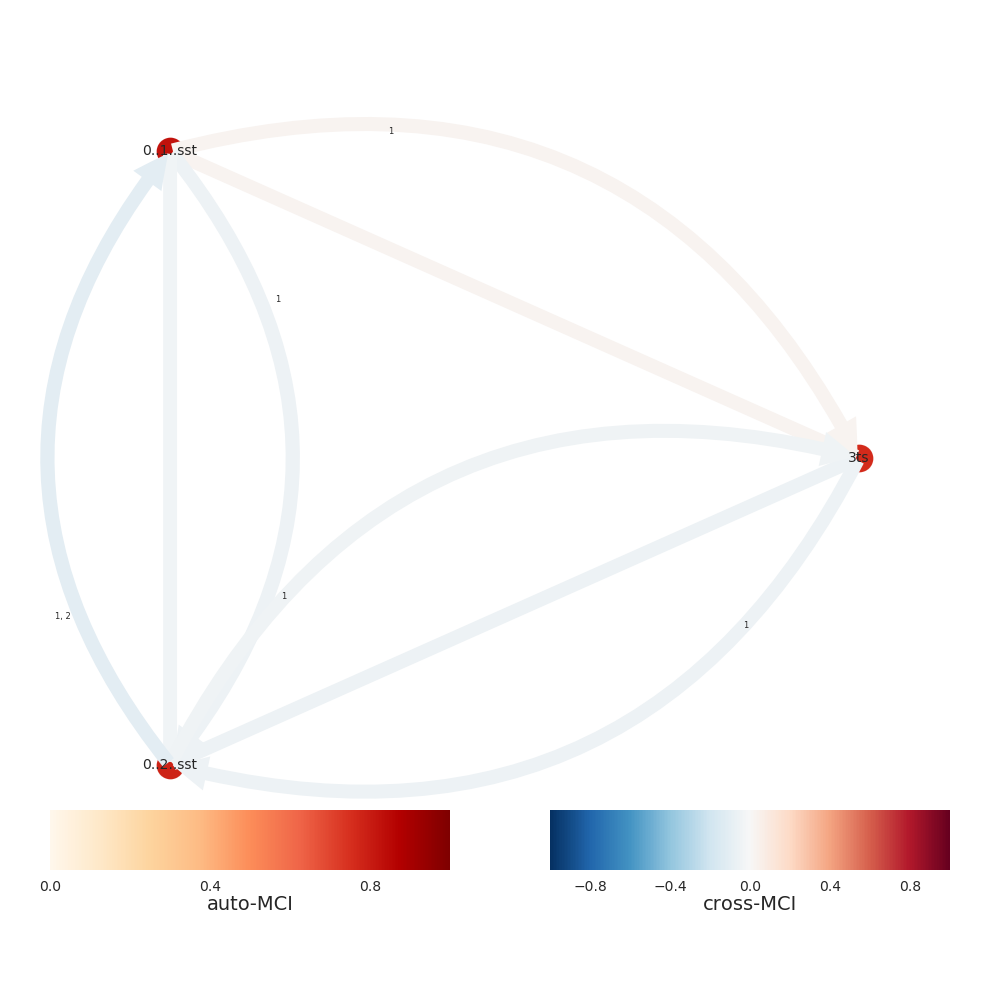

In [141]:
rg.PCMCI_df_data(tau_max=2, pc_alpha=0.05)
rg.PCMCI_get_links()
rg.df_MCIc
rg.PCMCI_plot_graph()

## Extracting data from RGCPD

In [142]:
rg_data  = rg.df_data.loc[:,rg.df_data.columns[rg.df_data.dtypes != bool]]
rg_index = rg_data.index.levels[1]
prec1_arr, prec2_arr = None, None
prec_list_arr = None
if len(rg_data.columns[1:].tolist()) == 2:    
    prec1_arr = rg_data.iloc[:,1].values
    prec2_arr = rg_data.iloc[:,2].values
more_precursors = False 
if len(rg_data.columns[1:].tolist()) > 2:
    more_precursors = True
    prec_list_arr = [rg_data.iloc[:,i].values
      for i in range(1, len(rg_data.columns[1:].tolist())+1)
      if len(rg_data.columns[1:].tolist()) > 2 ]

target_arr = rg_data.iloc[:,0].values
target_df = rg_data.iloc[:,0]

In [143]:
target_col = rg_data.columns.tolist()[0]
precursor_names = rg_data.columns.tolist()[1:]

In [144]:
precursor_names

['0..1..sst', '0..2..sst']

In [145]:
target_col

'3ts'

In [146]:
rg_index

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=14600, freq=None)

# Wavelet

## Variable wavelet options 

In [147]:
la8 = wa.create_least_asymmetric_filter(mode='dwt')
waves = ['sym2', 'sym4', 'sym8', la8]

## Plot wavelet decomposition

In [148]:
def plot_dwt_default(data, w, title, level, mode, method='wavedec'):

    assert isinstance(w, wv.Wavelet)
    a = data
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print(f"Appropriate level is changed to {level}")
    else:
        level_ = None
        
    if method == 'coeff':
        plot_coeffs(data, w, mode, title, level)
        return
    elif method =='recon':
        plot_signal_decomp(data, w, mode, title, level)
        return
    elif method =='modwt':
        plot_modwt(data, w, title, level)
        return
    else:
        coeffs =  wv.wavedec(a, w, level=level, mode=mode)

        ylim = [a.min(), a.max()]

        fig, axes = plt.subplots(len(coeffs) + 1, figsize=(10, 8), constrained_layout=True)
        axes[0].set_title(title)
        axes[0].plot(a, 'k', label='Original signal')
        axes[0].set_ylabel(r'C$^{\circ}$')
        axes[0].set_xlim(0, len(a) - 1)
        axes[0].set_ylim(ylim[0], ylim[1])
        axes[0].legend(loc=0)

        for i, _ in enumerate(coeffs):
            ax = axes[-i - 1]
            if i == 0:
                ax.set_ylabel("A%d" % (len(coeffs) - 1))
                ax.plot( coeffs[i], 'r')
            else:
                ax.set_ylabel("D%d" % (len(coeffs) - i))
                ax.plot( coeffs[i], 'g')

## Decompose and reconstruct signal 

In [149]:
def get_pad_width(data):
    x  = np.log2(len(data))
    x = math.ceil(x) 
    diff = 2**x - len(data)
    return diff//2

def get_pad_level(data):
    return math.ceil(np.log2(len(data)))

def get_pad_data(data):
    pad_width = get_pad_width(data)
    return np.pad(data, pad_width=pad_width, mode='reflect')

def unpad_data(data, pad_width):
    return data[pad_width:-pad_width]
def decompose_signal(data, w, mode, level, debug=False):
    assert isinstance(w, wv.Wavelet)
    cA, cD = [] , []
    s_prec  = data 
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print(f"Appropriate level is changed to {level}")
    else:
        level_ = None
    for i in range(level):
        s_prec, det  = wv.dwt(s_prec, w, mode=mode)
        cA.append(s_prec)
        cD.append(det)
    if debug:
        print(f'[DEBUG]')
        for i, value in enumerate(cD):
            print(f' Level {i} decomposition Length coefficient {value}')
    return cA, cD, level 
def decompose_signal_modwt(data, w, mode, level, unpad=True,  debug=True):
    assert isinstance(w, wv.Wavelet)
    pad_width = get_pad_width(data)
    a = get_pad_data(data=data)
    level_ = get_pad_level(data)
    if level > level_:
        level = level_
        print("[INFO] Appropriate level is changed to ", level)
    else:
        level_ = None

    coeffs =  wv.swt(a, w, level=level, trim_approx=True, norm=True) #[(cAn, (cDn, ...,cDn-1, cD1)]
    if unpad:
        temp = []
        for i, coeff in enumerate(coeffs):
            if debug:
                print(f'Length unpadded coeffs {len(coeff)}\n')
            temp.append(unpad_data(coeff, pad_width))
            if debug:
                print(f'Length after padding {len(temp[i])}\n')
        return temp
    else:
        return coeffs
def reconstruct_signal(data, w, mode, level, debug=False):
    """Decompose and reconstruct S.
    S = An + Dn + Dn-1 + ... + D1
    """
    assert isinstance(w, wv.Wavelet)
    a = data
    ca = []
    cd = []
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        print("Appropriate level is changed to ", level)
    else:
        level_ = None 
    for i in range(level):
        (a, d) = wv.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(wv.waverec(coeff_list, w, mode=mode))
        if debug:
            print(f'[DEBUG] Length reconstruction approx  index {len(coeff_list)} length coeffs {len(coeff)} length recon {len(rec_a[i])}')

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(wv.waverec(coeff_list, w, mode=mode))
    return rec_a, rec_d, ca, cd

## Extract and rebuild signal

In [150]:
def extract_signal_at_level(original_signal, signal, level):
#     print(f"[INFO] Level to extract {level} and length signal coeffs {len(signal)}")
    assert len(signal[level]) <= len(original_signal), f"[ERROR] Wavelet introduce longer signal length at given level {len(signal[level])} vs data length {len(original_signal)} "
    return signal[level] if level <= len(signal) else None

In [151]:
def check_correct_level_extracted(ex_signal, signal, level, modwt=True):
    assert level != len(signal), f"[ERROR] Array start at 0, so do not confuse level {level} decomp and length of signal {len(signal)}\n"
    if not modwt == True:
        return np.array_equiv(ex_signal, signal[level])
    else:
        return np.allclose(ex_signal, signal[level])

In [152]:
def build_up_to_level(data, w, mode, level, to_omit_level, debug=False):
    if debug == True:
        print('[INFO] Know that to_omit_level needs to be 1 indexed instead of 0 indexed')
    
    level_ = wv.dwt_max_level(len(data), w.dec_len)
    if level > level_:
        level = level_
        if debug == True:
            print("[INFO] Appropriate level is changed to ", level)
    else:
        level_ = None 
        
    coeffs  = wv.wavedec(data, w, mode, level)
    if debug == True:
        print(f'[INFO] Length decomposed coefficients is {len(coeffs)} to omit level size {to_omit_level+1} + 1')
    
    assert to_omit_level+1 <= len(coeffs), f"[ERROR] To omit level need to be  strictly one less than decomposition {level} and length coeffs {len(coeffs)}"
    coeffs[-to_omit_level+1] = np.zeros_like(coeffs[-to_omit_level+1])
    return wv.waverec(coeffs, w, mode)

In [153]:
def build_up_modwt_level(data, w, mode, level, to_omit_level, debug=False):
    assert isinstance(w, wv.Wavelet)
    if debug == True:
        print('\n[INFO] Know that to_omit_level needs to be 1 indexed instead of 0 indexed')
    a = get_pad_data(data=data)
    pd_width = get_pad_width(data)
    level_ = get_pad_level(data)
    if level > level_:
        level = level_
        if debug == True:
            print(f"\n[INFO] Appropriate level is changed to  {level}")
    else:
        level_ = None

    coeffs =  wv.swt(a, w, level=level, trim_approx=True, norm=True) #[(cAn, (cDn, ...,cDn-1, cD1)]
    if debug:
        print(f'[INFO] Length decomposed coefficients is {len(coeffs)} to omit level size {to_omit_level+1} + 1')

    assert to_omit_level+1 <= len(coeffs), f"\n[ERROR] To omit level need to be strictly one less than decomposition {level} and len coeffs {len(coeffs)}"
    coeffs[-to_omit_level+1] = np.zeros_like(coeffs[-to_omit_level+1])
    return unpad_data(wv.iswt(coeffs, w, mode), pad_width=pd_width)

In [154]:
def get_precursor_from_target_decomposition(low_freq_signal, high_freq_signal, original_signal, extract_at, wave, mode, modwt=False, debug=False):
    if debug == True:
        print(f'\n[INFO] Give modwt as high_freq_signal and set low_freg_signal to None' )
    if not modwt == True:
        ex_td = extract_signal_at_level(signal=high_freq_signal, level=extract_at, original_signal=original_signal)
        ex_ta = extract_signal_at_level(signal=low_freq_signal, level=extract_at, original_signal=original_signal)
        if check_correct_level_extracted(ex_signal=ex_td, signal=high_freq_signal, level=extract_at) and \
        check_correct_level_extracted(ex_signal=ex_ta, signal=low_freq_signal, level=extract_at):
            return wv.waverec([ex_ta, ex_td], wave, mode)
    else:
        ex_mod = extract_signal_at_level(signal=high_freq_signal, original_signal=get_pad_data(original_signal), level=extract_at)
        if check_correct_level_extracted(ex_signal=ex_mod, signal=high_freq_signal, level=extract_at, modwt=modwt):
 
            pd_width = get_pad_width(original_signal)
            padded_signal = unpad_data(data=ex_mod, pad_width=pd_width)
            return padded_signal

### Plot reconstructed signal

In [155]:
def plot_unpad_modwt(coeffs, title, data):
    _, axes = plt.subplots(len(coeffs) + 1, figsize=(10, 8), constrained_layout=True, dpi=120)
    axes[0].set_title(title)
    axes[0].plot(data, 'k', label='Original signal')
    axes[0].set_ylabel(r'C$^{\circ}$')
#     axes[0].set_xlim(0, len(coeffs[0]) - 1)

    axes[0].legend(loc=0)
    for i, _ in enumerate(coeffs):
        ax = axes[-i - 1]
        if i == 0:
            ax.set_ylabel("A%d" % (len(coeffs) - 1))
            ax.plot( coeffs[i], 'r')
        else:
            ax.set_ylabel("D%d" % (len(coeffs) - i))
            ax.plot( coeffs[i], 'g')

# Stationarity check

In [156]:
import synthetic_data as sd 
from statsmodels.regression.linear_model import yule_walker



def preprocess_ts(serie, col, threshold=0.05, to_serie=True,  debug=False):
    from scipy.stats import normaltest
    print(f'\n[INFO] Preprocessing Time serie \'{col}\' with first standardising and checking for gaussian like p-value ')
    normalize = lambda x : (x - x.mean())/ x.std()
    serie = serie.apply(normalize, axis=0)
    p_value = normaltest(serie)[1][0]
    print(f'\n[INFO] Time serie p_value  {p_value}  ')
    if p_value < threshold :
        print('\n[INFO] Time serie is gaussian like \n')
        if to_serie:
            return serie[col]
        else:
            return serie[col].values

In [157]:
def evaluate_data_ar(data, order=2, method='mle'):
    return yule_walker(data, order, method)

# Causal Effect Network

## Per level and lag included

In [158]:
def per_level_mci(cA, cA_t, rg, rg_index, level_test=True, tau_min=0,  tau_max=2, pc_alpha=0.05, debug=False):
    obj_rgcpd = []
    obj_pmatrix = []
    for i in range(0,len(cA_t)):
        idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(cA_t[i]) ).strftime('%Y-%m-%d') )
        idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cA) ).strftime('%Y-%m-%d') )

        dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-01', '08-31'), start_end_year=None, lpyr=False)
        full_time  = idx_lvl_t
        RV_time  = dates
        RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
        trainIsTrue = pd.Series(np.array([True for _ in range(len(cA_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
        if level_test:
            ts_ca1 = pd.Series(cA, index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
            ts_ca_shift = pd.Series(cA, index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_shift_lvl_'+ str(i)+'_dec')
            ts_tca1 = pd.Series(cA_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
            df = pd.concat([ts_tca1, ts_ca1, ts_ca_shift, trainIsTrue, RV_mask], axis=1)
            
            if i == 0 or i == 1:
                shift = 2**(i+1)
                new_index = pd.MultiIndex.from_product(([0], pd.DatetimeIndex(pd.date_range(rg_index[0] , periods=len(cA_t[i])+shift, freq='D' ).strftime('%Y-%m-%d'))))
                df.reindex(new_index)
                df.iloc[:,2] = df.iloc[:,2].shift(periods=shift)
            else:
                shift_ = 2**(i)
                new_index = pd.MultiIndex.from_product(([0], pd.DatetimeIndex(pd.date_range(rg_index[0] , periods=len(cA_t[i])+shift_, freq='D' ).strftime('%Y-%m-%d'))))
                df.reindex(new_index)
                df.iloc[:,2] = df.iloc[:,2].shift(periods=shift_)

        else:
            ts_ca1 = pd.Series(cA, index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_lvl_'+ str(i)+'_dec')
            ts_tca1 = pd.Series(cA_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
            df = pd.concat([ts_tca1, ts_ca1, trainIsTrue, RV_mask], axis=1)

        if any(df.isnull().sum() > 0) :
            df.dropna(inplace=True)

        rg.df_data = df
        rg.PCMCI_df_data(tau_min= tau_min, tau_max=tau_max, pc_alpha=pc_alpha)
        rg.PCMCI_get_links()
        rg.df_MCIc
        obj_rgcpd.append(deepcopy(rg.df_MCIc))
        obj_pmatrix.append(deepcopy(rg.pcmci_results_dict[0]['p_matrix']))
        if debug == True:
#             if i in [0, 2, 5, len(cA_t)-1]:
            if i in list(range(5)):
                rg.PCMCI_plot_graph()
                plt.show()
    return obj_rgcpd, obj_pmatrix

In [159]:
def extract_mci_lags(to_clean_mci_df, lag=0):
    assert len(to_clean_mci_df[0].values[:,lag][:])> 1, f'[ERROR] NO MCI component because length {len(to_clean_mci_df[0].values[:,lag][:])} '
    lag_target = [lags.values[:,lag][0] for _, lags in enumerate(to_clean_mci_df)]
    lag_precurs = [lags.values[:,lag][1] for _, lags in enumerate(to_clean_mci_df)]
    return lag_target, lag_precurs

## Default CEN no lags or wavelet included

In [160]:
def set_up_rgcpd_format(precursor, target, col=['mod_3ts', '3ts'], period=('06-01', '08-31'), index=rg_index):
    df_precursor  = pd.DataFrame(data=precursor, index=pd.MultiIndex.from_product(([0], index)), columns=[col[0]])
    df_precursor = preprocess_ts(df_precursor, col[0])
    target_df = pd.DataFrame(data=target, index= pd.MultiIndex.from_product(([0], index)), columns=[col[1]])
    target_df = preprocess_ts(target_df, col[1])
    dates = core_pp.get_subdates(dates=index, start_end_date=period, start_end_year=None, lpyr=False)
    RV_mask = pd.Series(np.array([True if d in dates else False for d in rg_index]), index=pd.MultiIndex.from_product(([0], index)), name='RV_mask')
    trainIsTrue = pd.Series(np.array([True for _ in range(len(target))]), index=pd.MultiIndex.from_product(([0], index)), name='TrainIsTrue')
    return pd.concat([target_df, df_precursor, trainIsTrue, RV_mask], axis=1)

In [161]:
def mci_default(dFrame, tau_min= 0,  tau_max=2, pc_alpha=0.05, debug=True):
    obj_rgcpd = []
    obj_pmatrix = []
    rg.df_data = dFrame
    rg.PCMCI_df_data(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha)
    rg.PCMCI_get_links()
    rg.df_MCIc
    obj_rgcpd.append(rg.df_MCIc)
#     obj_pmatrix.append(deepcopy(rg.pcmci_results_dict[0]['p_matrix']))
    if debug == True:
        rg.PCMCI_plot_graph()
        plt.show()
    return obj_rgcpd, obj_pmatrix

In [162]:
def extract_mci_pmatrix(yprime, x_diff, rg_index, columns):
    dFrame = set_up_rgcpd_format(precursor=x_diff, target=yprime, col=columns)
    obj_rgcpd, obj_pmatrix = mci_default(dFrame)
    _, lag_precursor = extract_mci_lags(obj_rgcpd, lag=0)
    return lag_precursor, obj_pmatrix

## Visualize MCI

In [163]:
def plot_mci_pred_relation(cA, prec_lag, path, title, show_level=False,  savefig=False):
    if show_level:
        x_as = np.arange(0, len(cA))
    else:
        x_as = np.arange(1, len(cA)+1)
        x_as = np.exp2(x_as)
    plt.figure(dpi=120)
    plt.plot(x_as, prec_lag, label='precrursor ')
    plt.vlines(x_as[np.argmax(prec_lag)], ymin=plt.ylim()[0], ymax=plt.ylim()[1],linestyles='dashed', label='MCI peak')
    
    if not show_level:
        plt.xscale('log', basex=2)
        plt.xticks(x_as, [str(2**i)+' days' for i in range(1, len(prec_lag)+1)], rotation=45) 
        plt.xlabel('Scales in daily means')
    else:
        plt.xticks(x_as,[str(i) for i in range(0, len(prec_lag)+1)] ) 
        plt.xlabel('Decomposition per level')
    plt.title(title)
    
    plt.ylabel('MCI')
    plt.legend(loc=0)
    if savefig ==True:
        Path('Wavelet/Mci/'+path).mkdir(parents=True, exist_ok=True)
        plt.savefig('Wavelet/Mci/'+path+'/MCI on scale wavelet on lag 0 of '+str(title)+' iteration.pdf', dpi=120)
        # plt.savefig('Wavelet/Mci/'+path+'/MCI on scale wavelet on lag 0 of '+str(title)+' iteration.png', dpi=120)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [164]:
def box_plot_reesult_experiments(result, level, theta, depth=0, show_level=True, title=r'Evaluation of sensitivity $\theta$ on modified target baseline'):
    
    kwargs ={ 'meanline':True, 'showmeans':True}

    df = pd.DataFrame(result)
    df.columns = [str(round(theta[i], 1)) for i in range(0, len(theta))]
    df.boxplot(**kwargs)

    plt.title(title)
    plt.xlabel(r'Variation $\theta$')

    if show_level == True:
        plt.ylabel(r'Level of decomposition ')
        plt.yticks(np.arange(0, len(level), 1), [str(i) for i in range(0, len(level))], rotation=45)
    else:
        plt.ylabel(r'Level of decomposition in timescale ')
        plt.yscale('log',basey=2) 
        plt.yticks(np.exp2(np.arange(1, len(level)+1)), [str(2**i) for i in range(1, len(level)+1)], rotation=45)

    
    plt.show()

# Experiment

## Set-up 

In [165]:
import multiprocessing as mp
prepro_target = preprocess_ts(serie=rg_data, to_serie=False, col=target_col)



[INFO] Preprocessing Time serie '3ts' with first standardising and checking for gaussian like p-value 

[INFO] Time serie p_value  7.183345924181194e-98  

[INFO] Time serie is gaussian like 



In [166]:
prepro_precursor_1 = preprocess_ts(serie=rg_data, to_serie=False, col=precursor_names[0]) # 0...1sst


[INFO] Preprocessing Time serie '0..1..sst' with first standardising and checking for gaussian like p-value 

[INFO] Time serie p_value  7.183345924181194e-98  

[INFO] Time serie is gaussian like 



In [167]:
prepro_precursor_2 = preprocess_ts(serie=rg_data, to_serie=False, col=precursor_names[1]) # 0...2sst


[INFO] Preprocessing Time serie '0..2..sst' with first standardising and checking for gaussian like p-value 

[INFO] Time serie p_value  7.183345924181194e-98  

[INFO] Time serie is gaussian like 



In [168]:
def modify_target(prepro_target, tar_arr, w, mode, level, to_omit_level, modwt=False):
    modified, X= None, None
    if modwt:
        modified = build_up_modwt_level(data=prepro_target, w=w, mode=mode,level=level, to_omit_level=to_omit_level)
        coeffs = decompose_signal_modwt(prepro_target, w, mode, level=level, unpad=False,  debug=False)
        X = get_precursor_from_target_decomposition(high_freq_signal=coeffs[1:], low_freq_signal=coeffs[0], original_signal=prepro_target, extract_at=to_omit_level, wave=w, mode=mode, modwt=True)
    else:
        modified = build_up_to_level(data=prepro_target, w=w, mode=mode,level=level, to_omit_level=to_omit_level)
        t_ca, t_cd, level = decompose_signal(prepro_target, w, mode, level)
        X = get_precursor_from_target_decomposition(t_ca, t_cd, prepro_target, to_omit_level , w, mode)
    return modified, X

In [169]:
def setup_equation(mod_target, x_diff, nu=1.0, gamma=1.0, eps=1.0, noise_test=False, lag=0):
    yprime = None
    if not noise_test:
        if lag > 0:
            yprime = nu * mod_target[lag:] + gamma * x_diff[:-lag] 
        else:
            yprime = nu * mod_target + gamma * x_diff
    else:
        if lag > 0:
            yprime = nu * mod_target[lag:] + gamma * x_diff[:-lag] + eps 
        else:
            yprime = nu * mod_target + gamma * x_diff + eps 
    return yprime

## Experiments values

In [170]:
gammas = np.arange(0.1, 1.1, 0.1)
theta = np.arange(0.1, 1.1, 0.1)
nus = np.arange(0.1, 1.1, 0.1)
levels = np.arange(0, 12, 1)
experiments = gammas
iteration = 100
p = mp.Pool(mp.cpu_count()-1)

### Frequency Known for given level decomposition wavelet

In [171]:
# Frequency band associated with level decomposition
[1/(2**(L + 1)) for L in levels]

[0.5,
 0.25,
 0.125,
 0.0625,
 0.03125,
 0.015625,
 0.0078125,
 0.00390625,
 0.001953125,
 0.0009765625,
 0.00048828125,
 0.000244140625]

### Frequency band during level decomposition

In [172]:
# Filtering signal frequency band per level decomposition
[[1/(2**(k +1)), 1/(2**k)] for k in levels]

[[0.5, 1.0],
 [0.25, 0.5],
 [0.125, 0.25],
 [0.0625, 0.125],
 [0.03125, 0.0625],
 [0.015625, 0.03125],
 [0.0078125, 0.015625],
 [0.00390625, 0.0078125],
 [0.001953125, 0.00390625],
 [0.0009765625, 0.001953125],
 [0.00048828125, 0.0009765625],
 [0.000244140625, 0.00048828125]]

## Functions for experiments

In [173]:
def run_experiment_levels(pre_target, prec, rg, rg_index, w=la8, peak_test=True,  mode=wv.Modes.periodic, total_levels=levels):
    obj_rg = []

    if peak_test:
        print(f'[INFO] Lag included in PCMCI step')
        coeffs = decompose_signal_modwt(pre_target, w, mode, level=len(total_levels), unpad=True,  debug=False)
        obj_rgcpd, _ = per_level_mci(prec, coeffs[1:], rg,  rg_index, debug=True, level_test=True, tau_min= 0, tau_max=0)

        _, lag_precursor = extract_mci_lags(obj_rgcpd, lag=0)
        obj_rg.append(lag_precursor)

        
    else:
        print(f'[INFO] No lag included in PCMCI step')
        coeffs = decompose_signal_modwt(pre_target, w, mode, level=len(total_levels), unpad=True,  debug=False)
        obj_rgcpd, _ = per_level_mci(prec, coeffs[1:], rg,  rg_index, debug=True, level_test=False, tau_min= 0, tau_max=0)

        _, lag_precursor = extract_mci_lags(obj_rgcpd, lag=0)
        obj_rg.append(lag_precursor)

    return obj_rg

In [174]:
def run_experiment_levels_noise(pre_target, prec, rg, rg_index, thetas=theta, w=la8, peak_test=True, modwt=True, mode=wv.Modes.periodic, total_levels=levels[:5], iterations=iteration):
    
    
    exper_result = {str(noise):None for noise in thetas}
    for noise_strength in thetas:
        print(f'\n[DEBUG] Running with noise {noise_strength}')
        mean_peak = np.zeros(iterations)
        for it in np.arange(0, iterations):
            print(f'\n[DEBUG] Iiteration {it}')
            if peak_test:
                
                coeffs = decompose_signal_modwt(pre_target, w, mode, level=len(total_levels), unpad=True,  debug=False)
                obj_rgcpd, _ = per_level_mci(prec, coeffs[1:],rg, rg_index, debug=False, level_test=True, tau_min=0,  tau_max=0)
                _, lag_precursor = extract_mci_lags(obj_rgcpd, lag=0)
#                 print( '\n[DEBUG] Before filling mean_peak ', mean_peak[it], '\n')
                mean_peak[it] = np.argmax(lag_precursor) 
                exper_result[str(noise_strength)] = mean_peak
#                 print( '\n[DEBUG] After filling mean_peak ', mean_peak[it], '\n')

            else:
                
                coeffs = decompose_signal_modwt(pre_target, w, mode, level=len(total_levels), unpad=True,  debug=False)
                obj_rgcpd, _ = per_level_mci(prec, coeffs[1:],rg, rg_index, debug=False, level_test=False, tau_min=0,  tau_max=0)
                _, lag_precursor = extract_mci_lags(obj_rgcpd, lag=0)
#                 print( '\n[DEBUG] Before filling mean_peak ',mean_peak[it], '\n')
                mean_peak[it] = np.argmax(lag_precursor)
                exper_result[str(noise_strength)] = mean_peak
#                 print( '\n[DEBUG] After filling mean_peak ',mean_peak[it], '\n')

                
    return exper_result

## Experiment plain Precursor 1 (Mid-pacific)

### Test plain no lag included in PCMCI

[INFO] No lag included in PCMCI step
Progress causal inference - traintest set 100%

/home/jier/miniconda3/envs/RGCPD/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


<IPython.core.display.Javascript object>


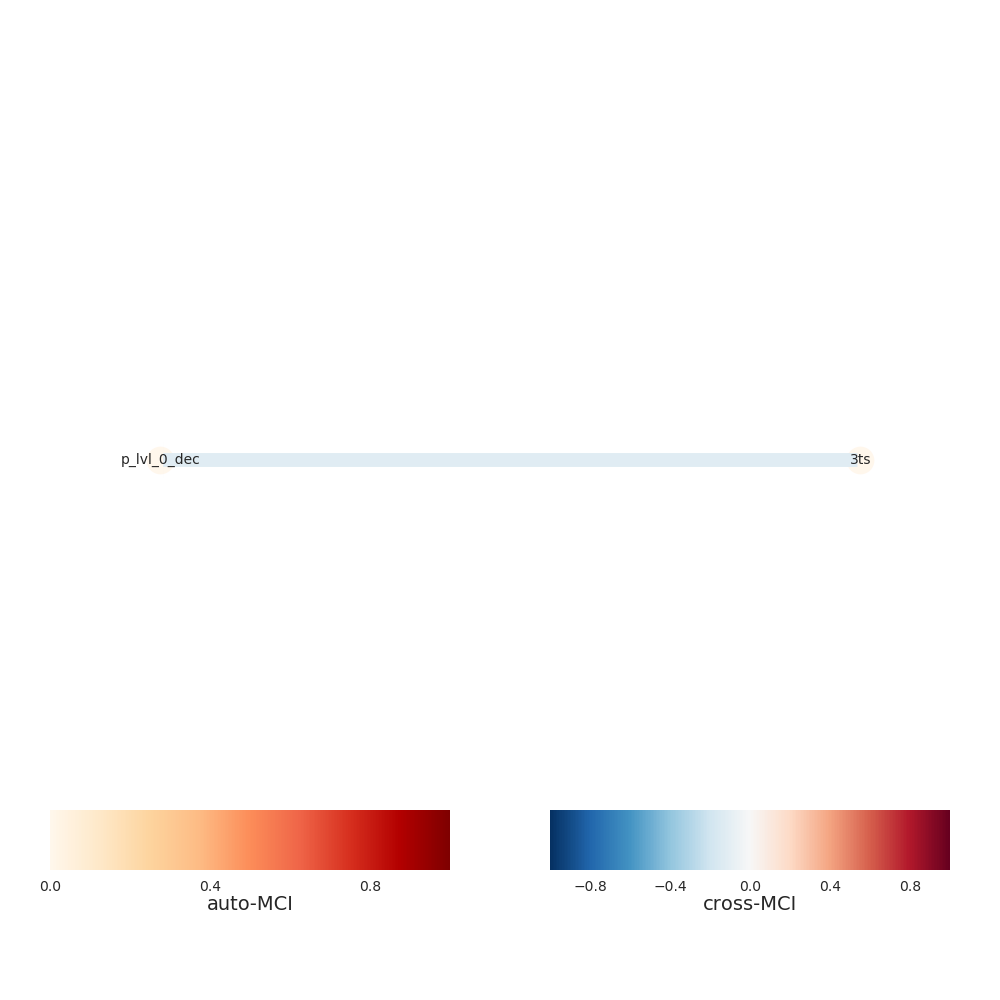

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


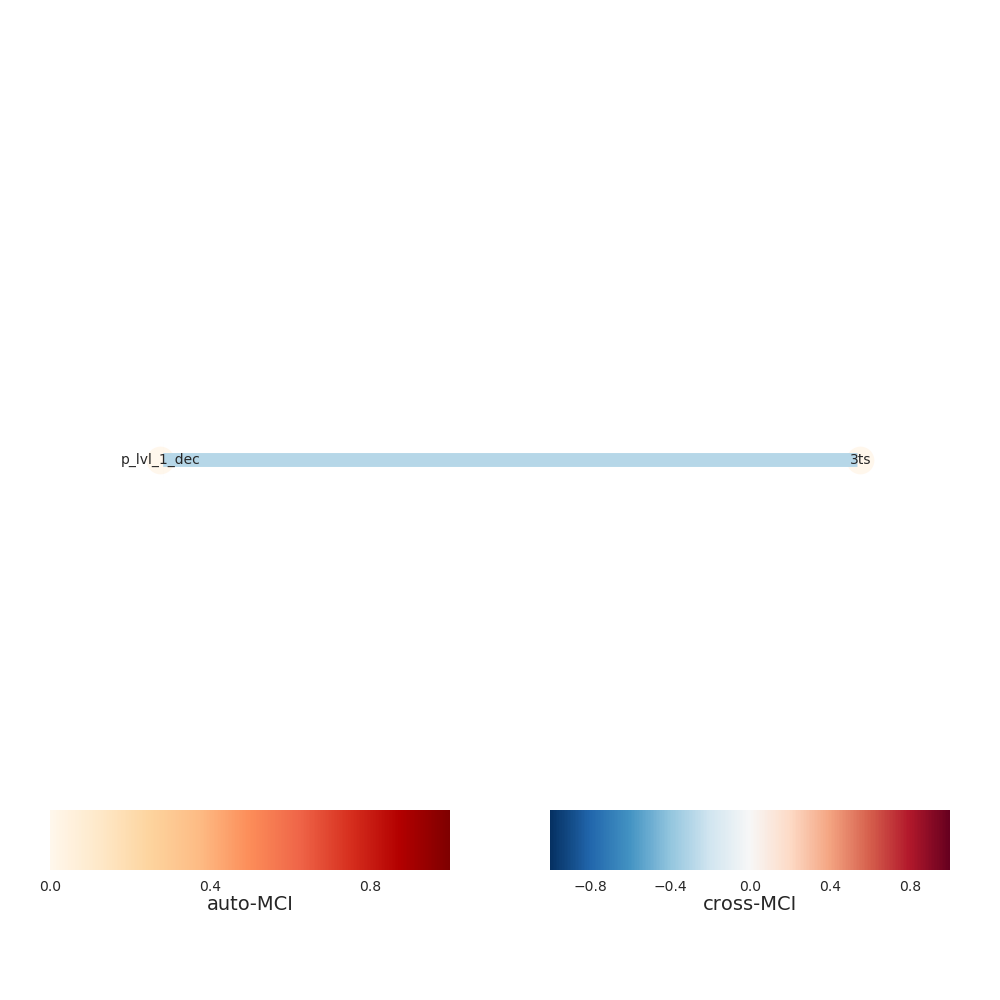

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


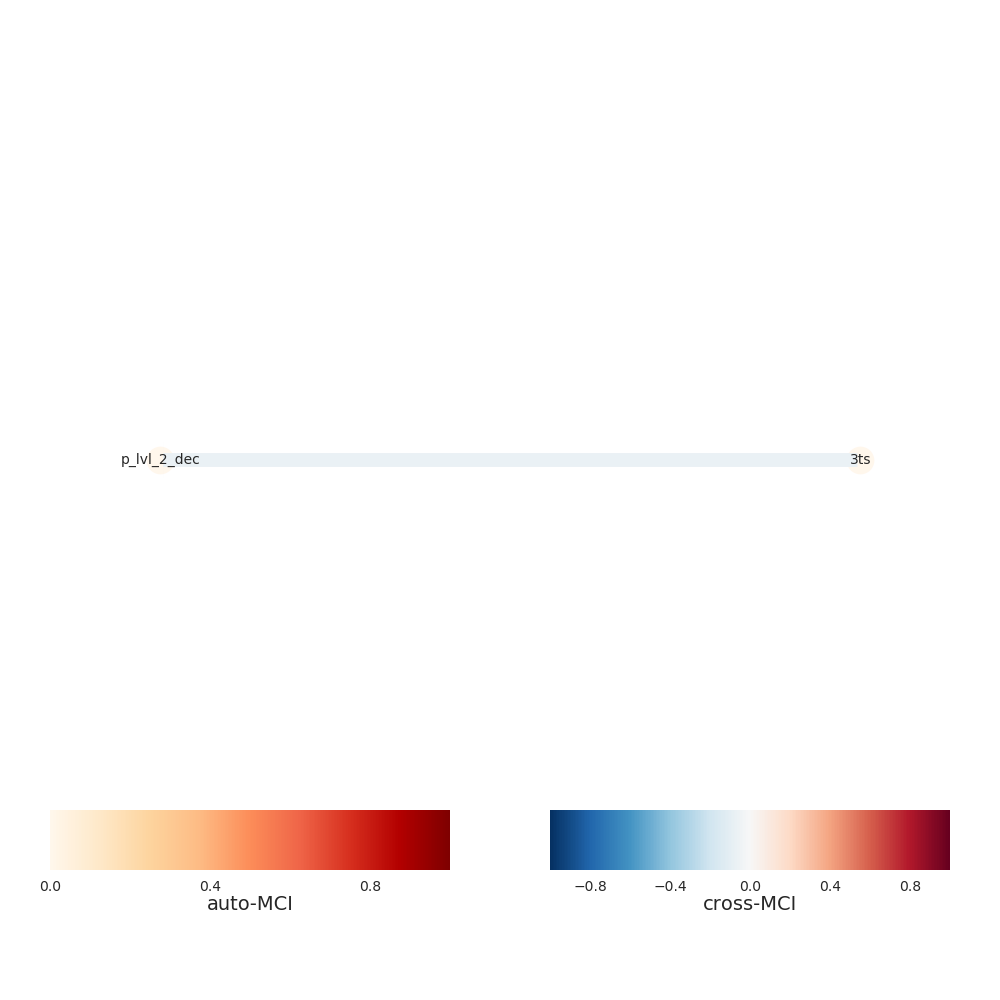

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


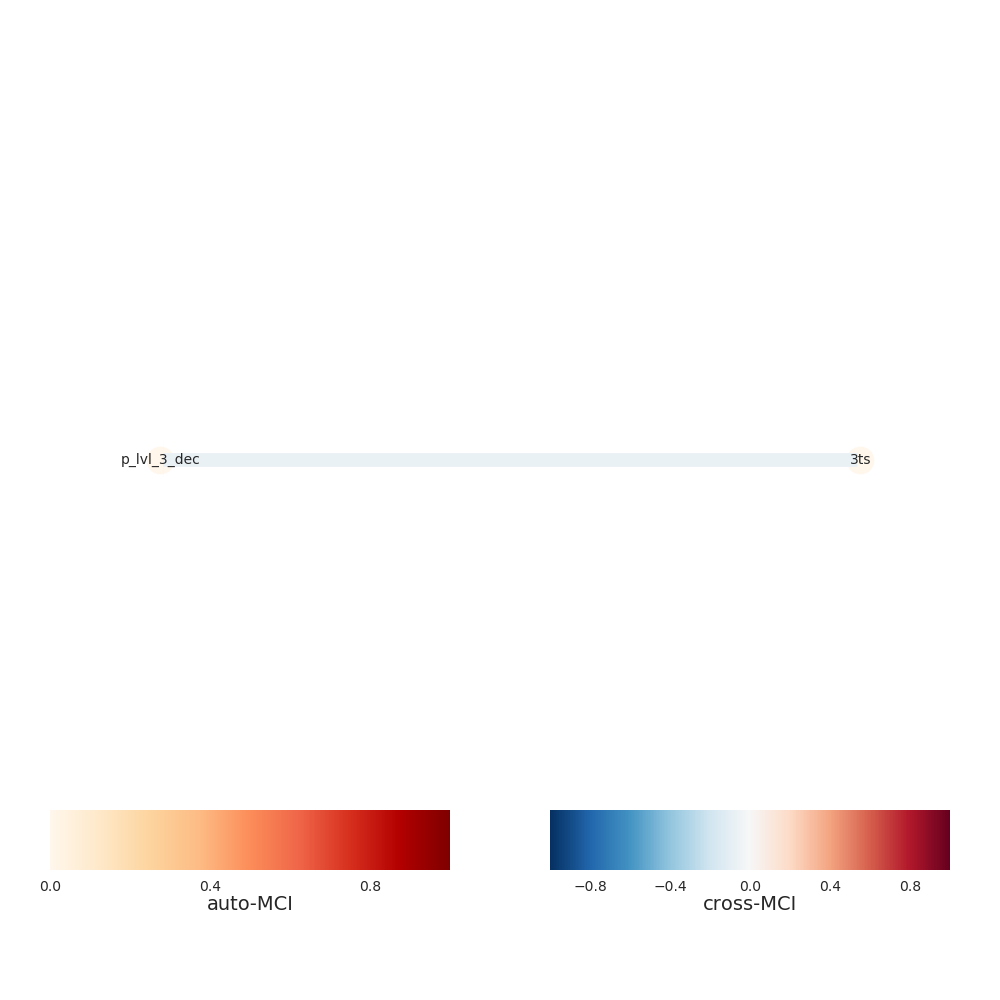

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


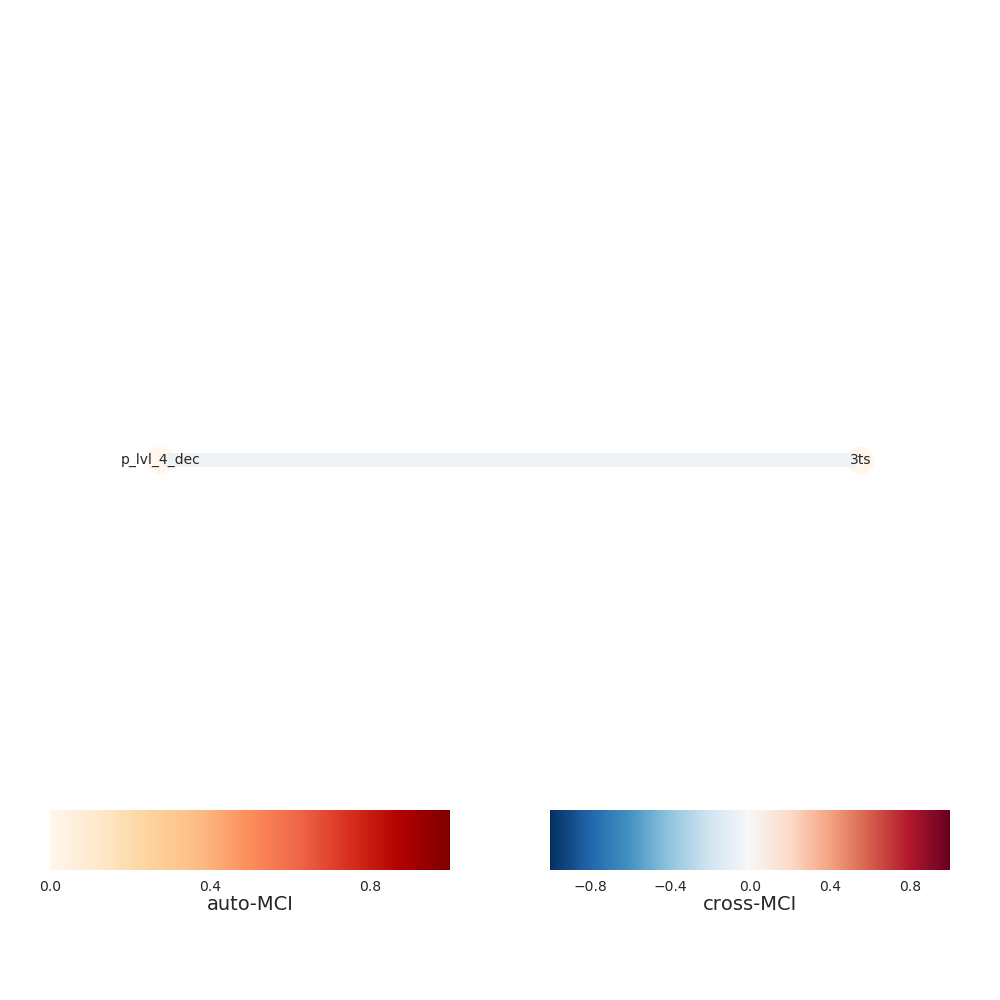

Progress causal inference - traintest set 100%

In [175]:
res_no_lag = run_experiment_levels(prepro_target, prepro_precursor_1, rg, rg_index, peak_test=False)

<IPython.core.display.Javascript object>


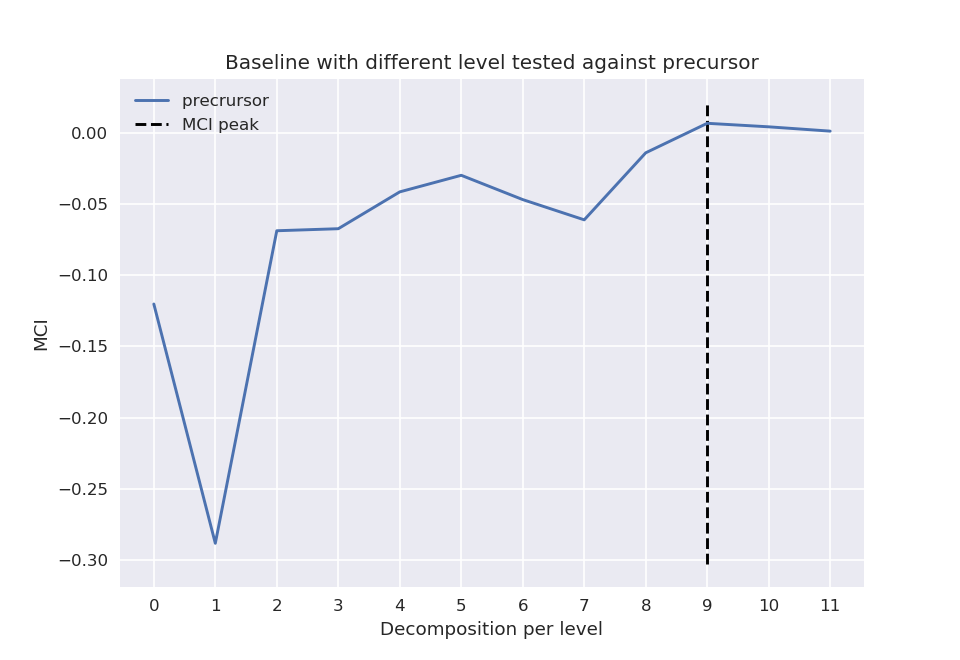

In [176]:
plot_mci_pred_relation(cA=np.arange(len(res_no_lag[0])), prec_lag=res_no_lag[0], path=' ', title=f'Baseline with different level tested against precursor', show_level=True, savefig=False)

### Test plain with no lag included

[INFO] Lag included in PCMCI step
Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


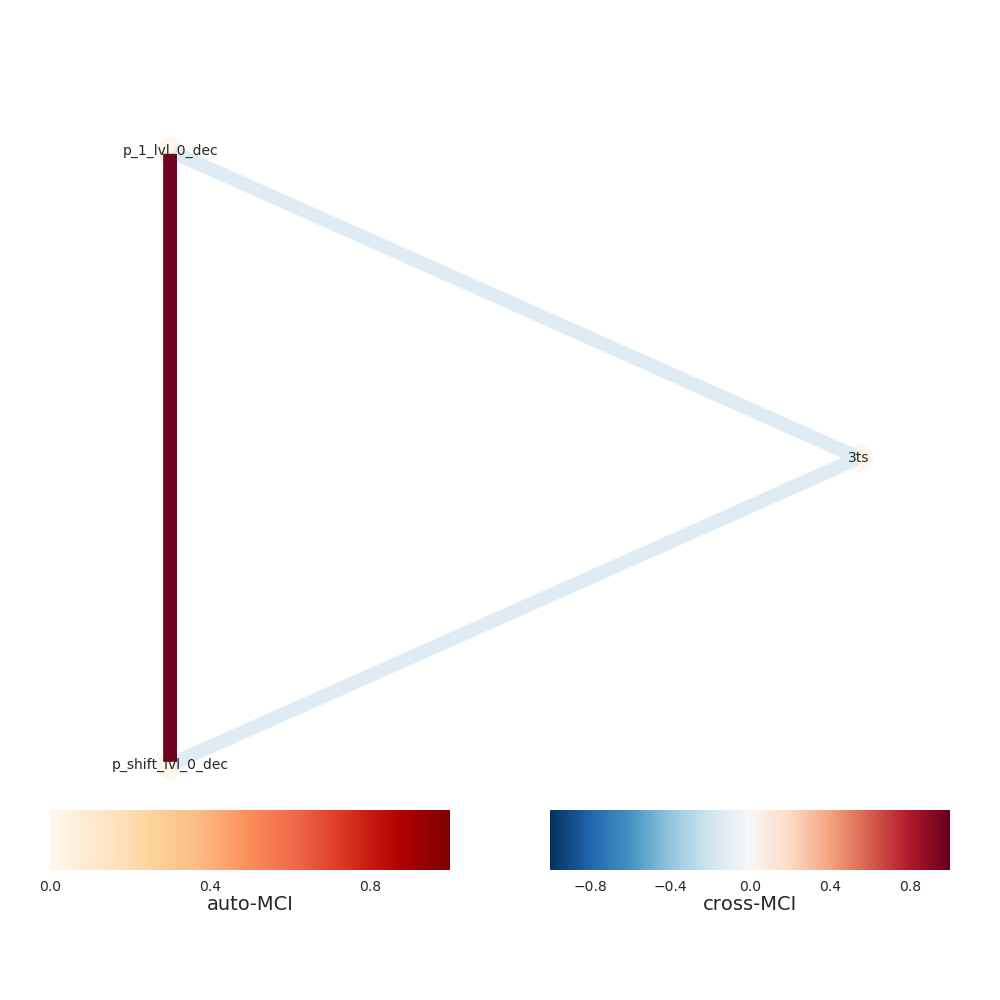

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


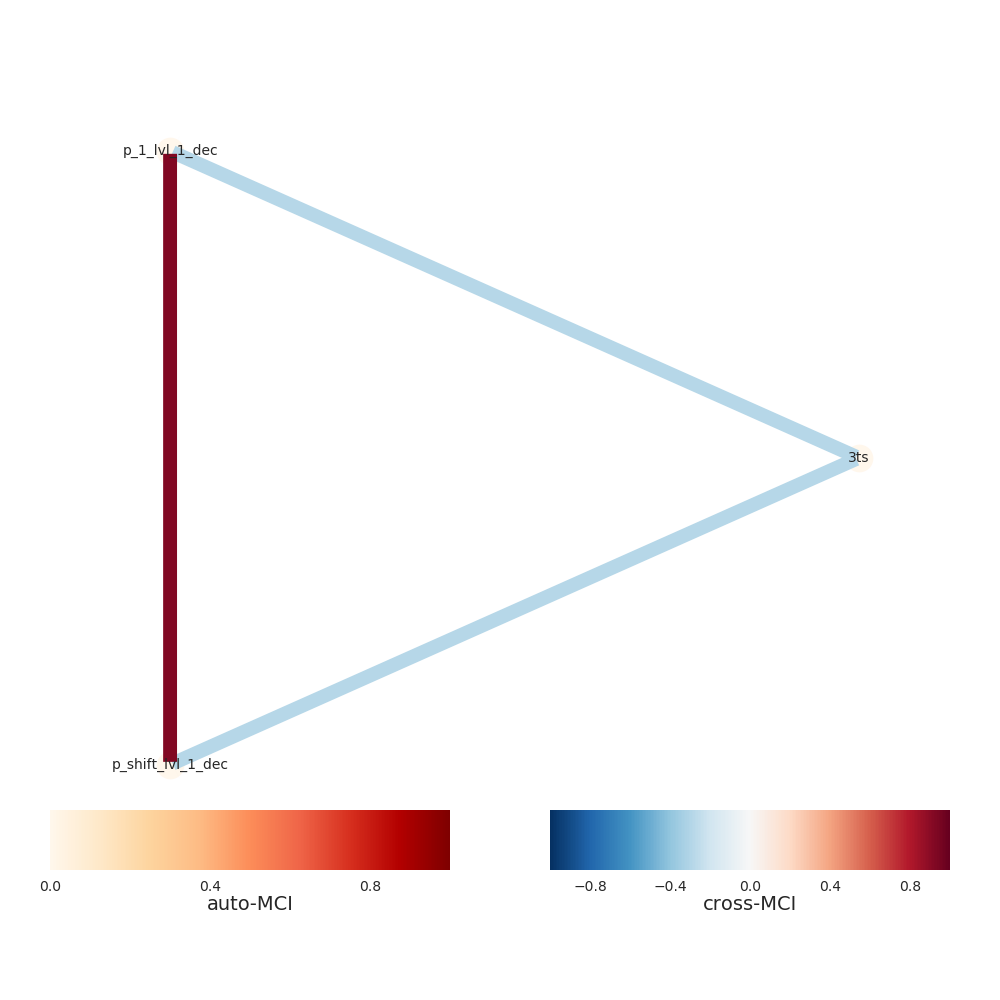

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


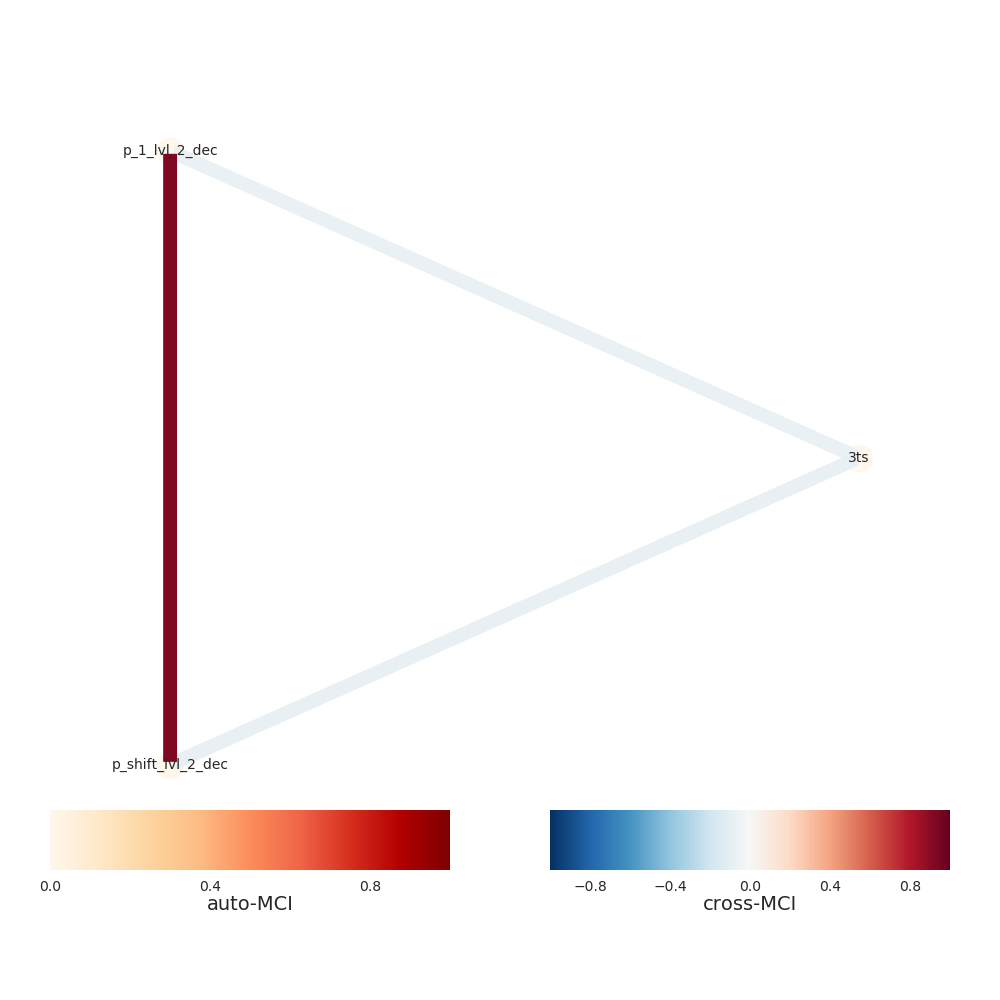

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


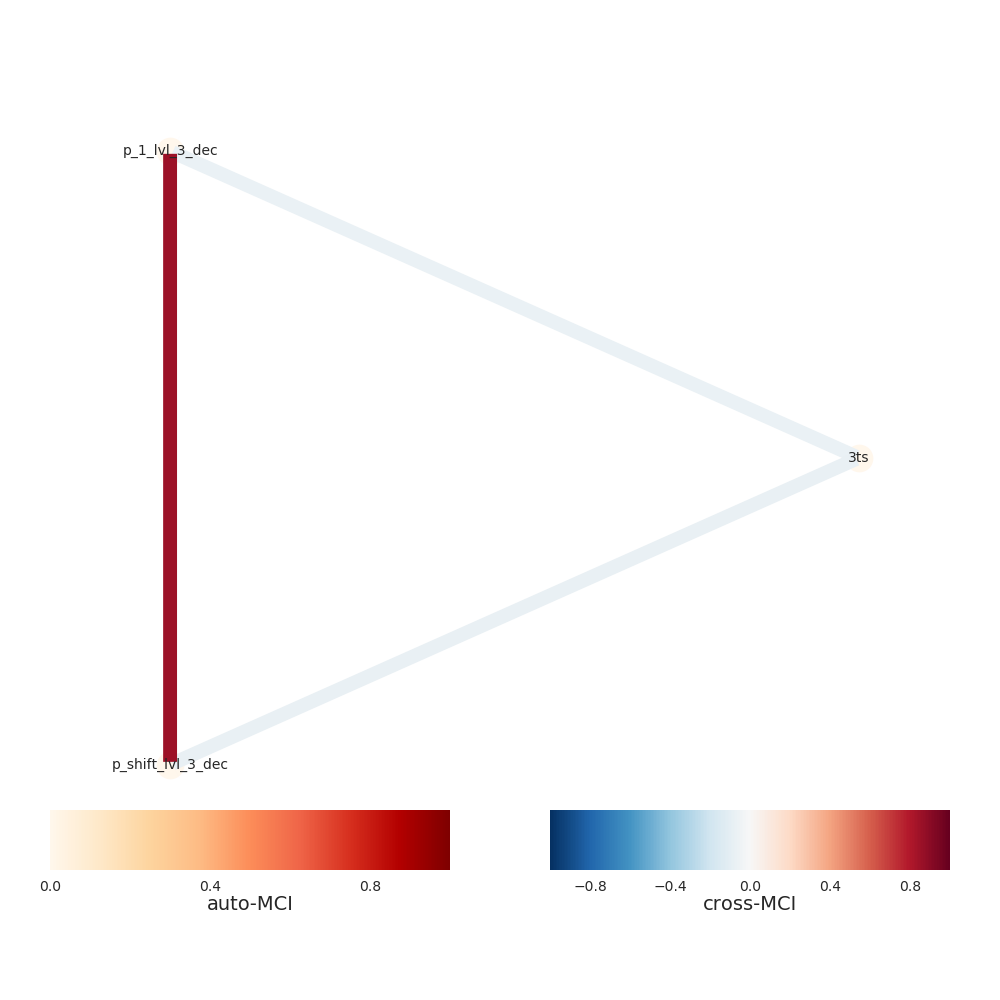

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


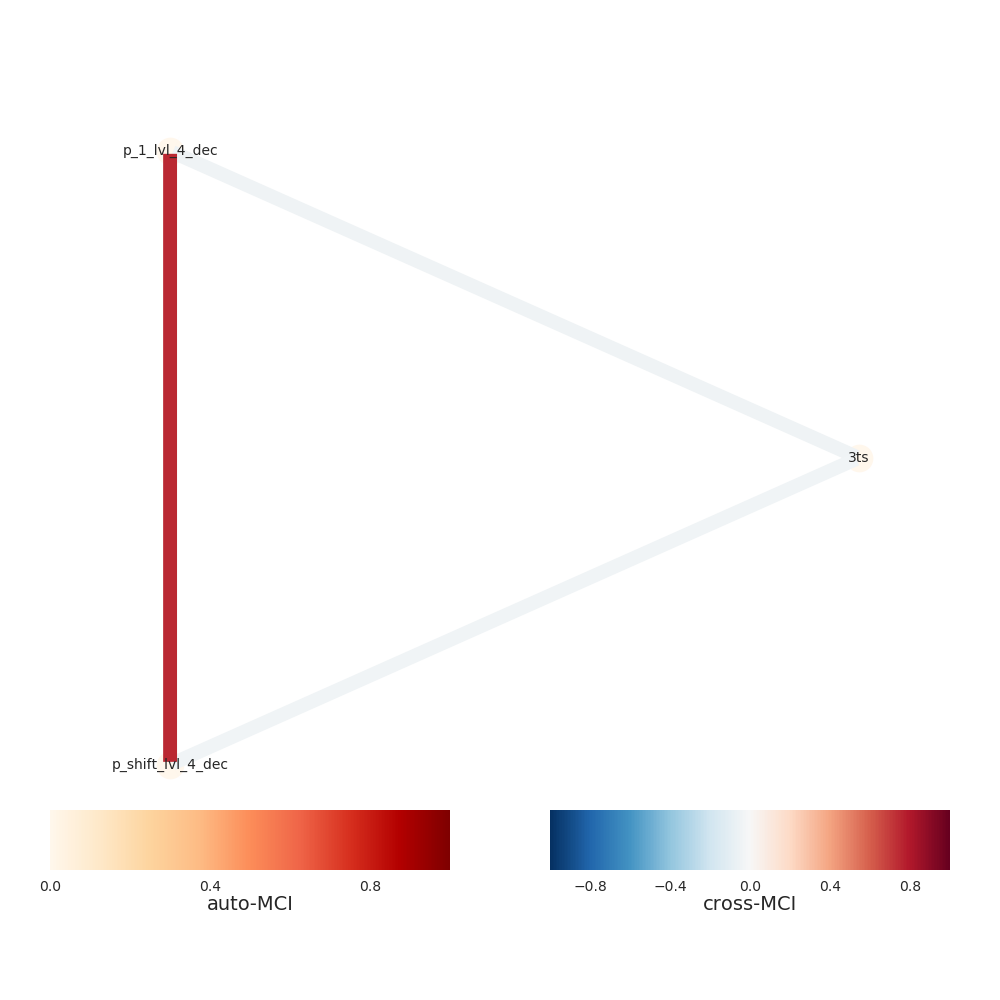

Progress causal inference - traintest set 100%

In [177]:
result_with_lag = run_experiment_levels(prepro_target, prepro_precursor_1, rg, rg_index, peak_test=True,total_levels=levels)

<IPython.core.display.Javascript object>


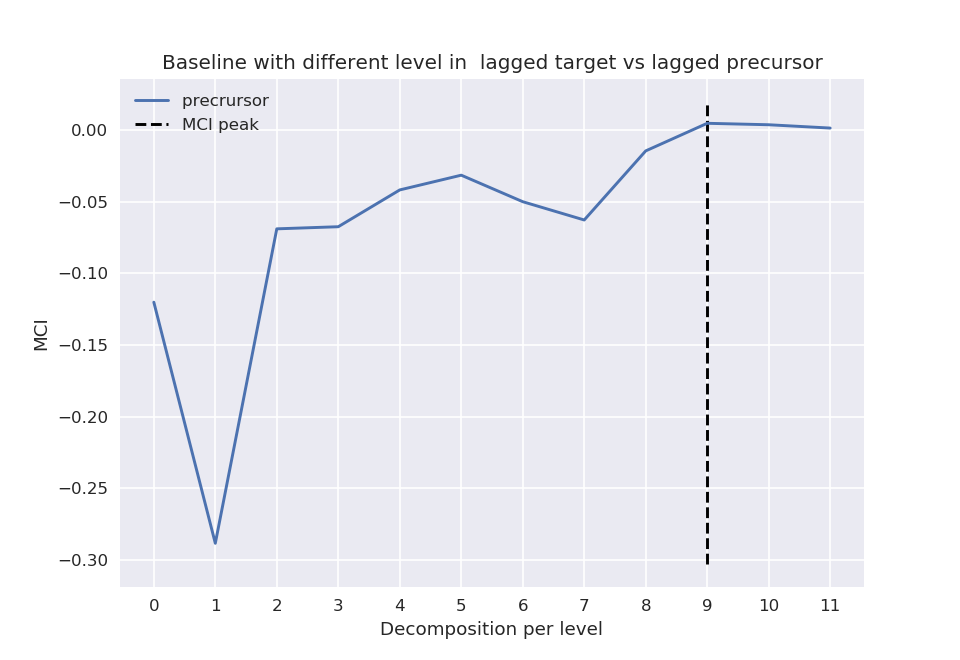

In [178]:
# for i, peak in enumerate(result_no_lag):
#     if abs(len(result_no_lag) - len(peak)) == 1:
#         plot_mci_pred_relation(cA=range(len(result_no_lag)-1), prec_lag=peak, path=' ', title=f'Baseline with different level {str(levels[i])} omitted \n lag shift included {str(2**(levels[i]))} days \n in precursor and target', show_level=True, savefig=False)
#     else:
#         plot_mci_pred_relation(cA=range(len(result_no_lag)), prec_lag=peak, path=' ', title=f'Baseline with different level {str(levels[i])} omitted \n lag shift included {str(2**(levels[i]))} days \n in precursor and target', show_level=True, savefig=False)
plot_mci_pred_relation(cA=range(len(result_with_lag[0])), prec_lag=result_with_lag[0], path=' ', title=f'Baseline with different level in  lagged target vs lagged precursor', show_level=True, savefig=False)

### Experiment noise

#### Noise with no lag included

In [179]:
result_noise = run_experiment_levels_noise(prepro_target, prepro_precursor_1 ,rg, rg_index, w=la8, peak_test=False, modwt=True, mode=wv.Modes.periodic, total_levels=levels, iterations=10, thetas=theta)


[DEBUG] Running with noise 0.1

[DEBUG] Iiteration 0
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 1
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 4
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 5
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 6
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 7
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 8
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 9
Progress causal inference - traintest set 100%
[DEBUG] Running with noise 0.2

[DEBUG] Iiteration 0
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 1
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
Progress causal inference - tr

<IPython.core.display.Javascript object>


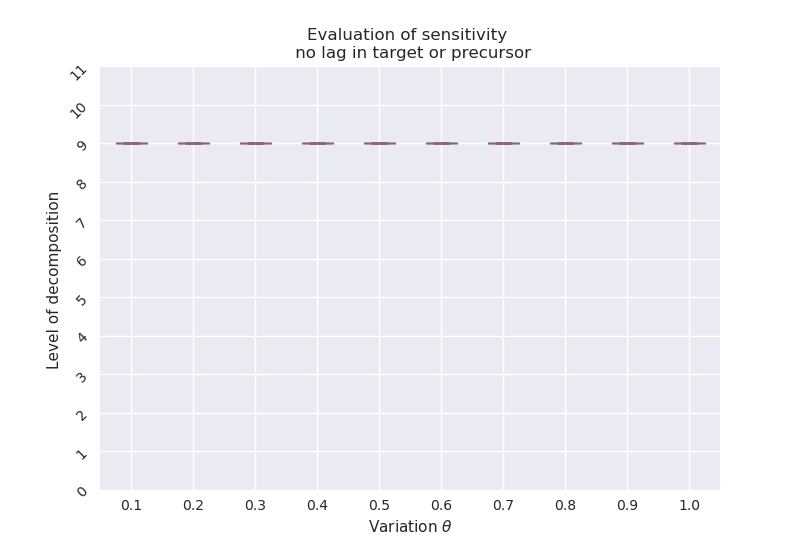

In [180]:
%matplotlib notebook
box_plot_reesult_experiments(result_noise, level=levels, theta=theta, title='Evaluation of sensitivity \n no lag in target or precursor')

#### Noise with lag included

In [128]:
result_noise_lag = run_experiment_levels_noise(prepro_target, prepro_precursor_1 ,rg, rg_index, w=la8, peak_test=True, modwt=True, mode=wv.Modes.periodic, total_levels=levels, iterations=10, thetas=theta)


[DEBUG] Running with noise 0.1

[DEBUG] Iiteration 0
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 1
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 4
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 5
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 6
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 7
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 8
[INFO] Appropriate level is changed to  11
Progress causal

Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 4
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 5
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 6
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 7
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 8
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 9
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Running with noise 0.9

[DEBUG] Iiteration 0
[INFO] Appro

<IPython.core.display.Javascript object>


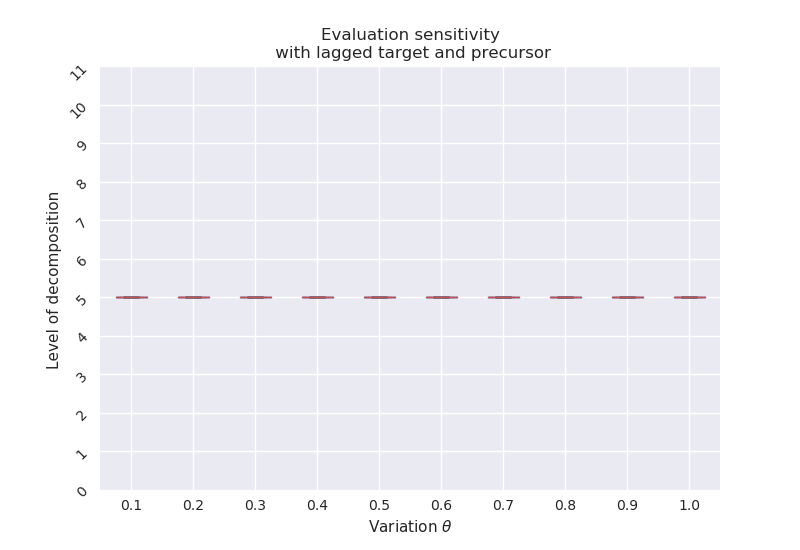

In [129]:
%matplotlib notebook
box_plot_reesult_experiments(result_noise_lag, level=levels, theta=theta, title='Evaluation sensitivity\n with lagged target and precursor')

## Experiment plain Precursor 2 (East-Pacific)

### Test plain no lag included in PCMCI step

[INFO] No lag included in PCMCI step
Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


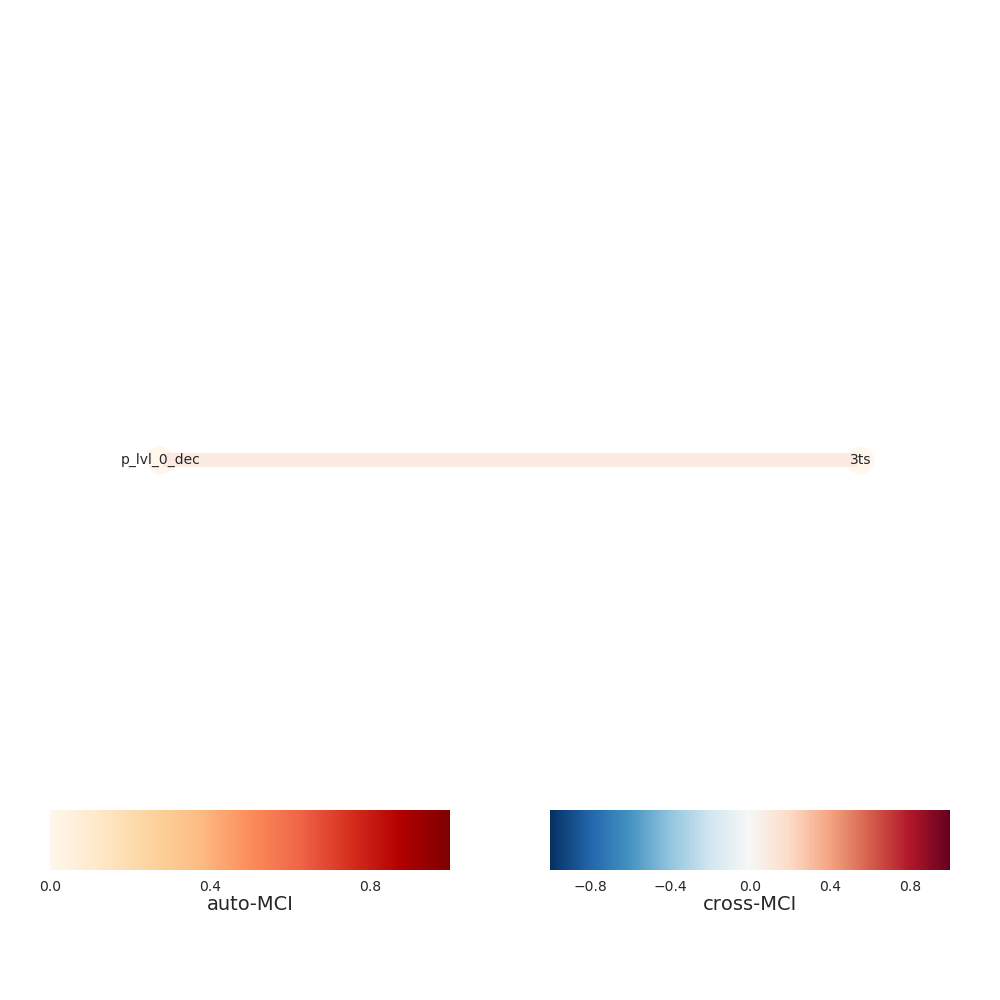

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


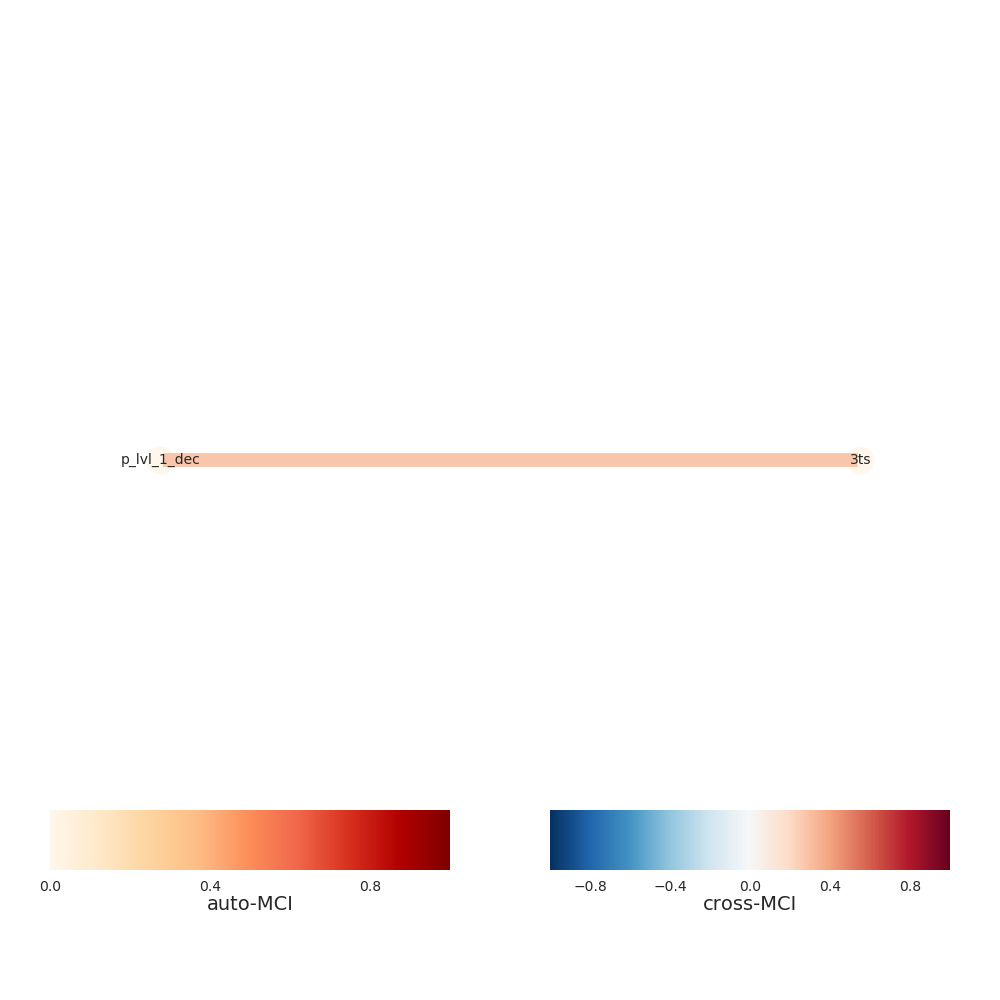

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


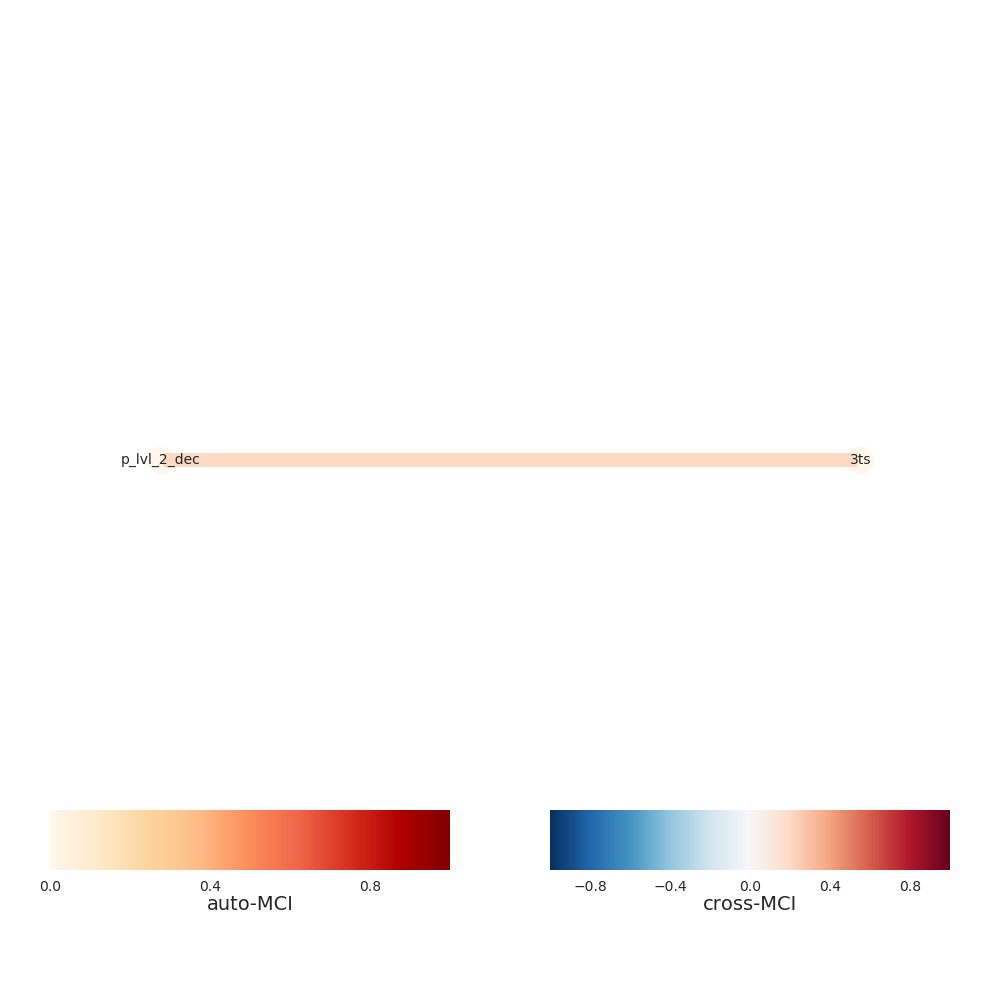

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


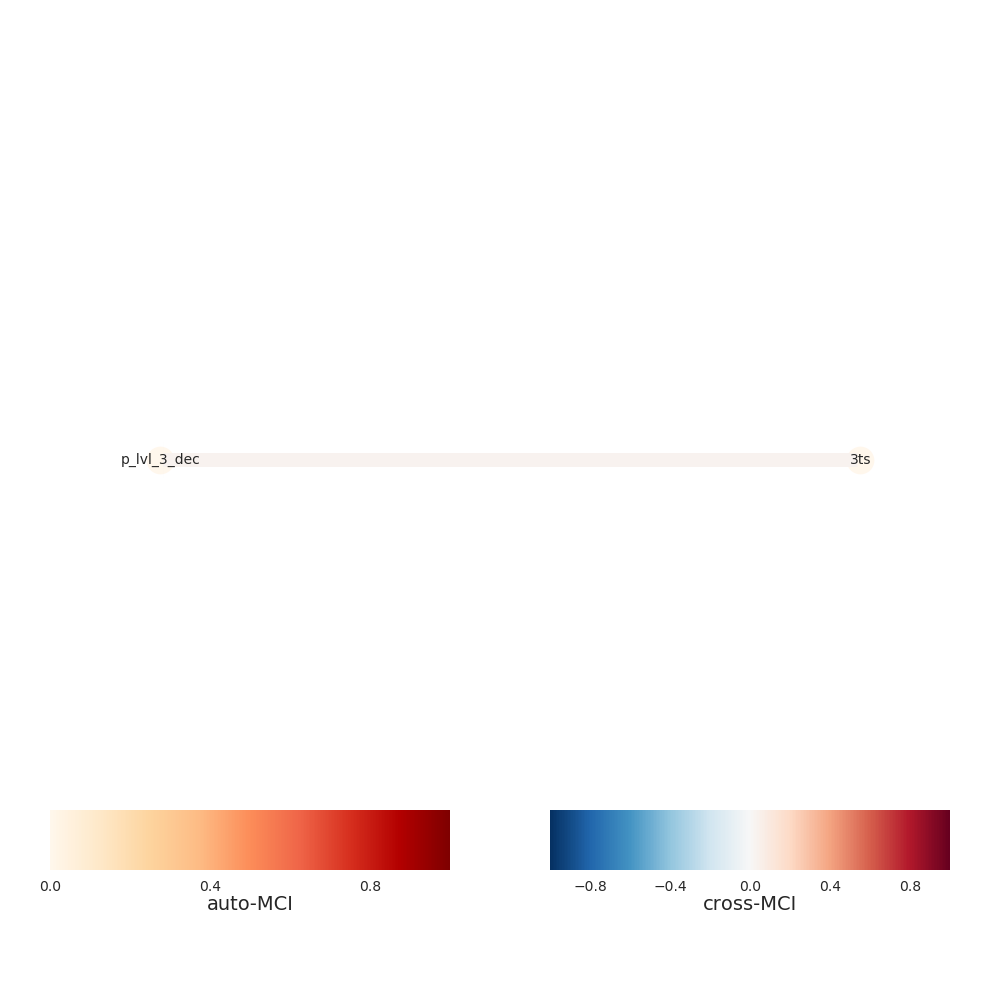

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


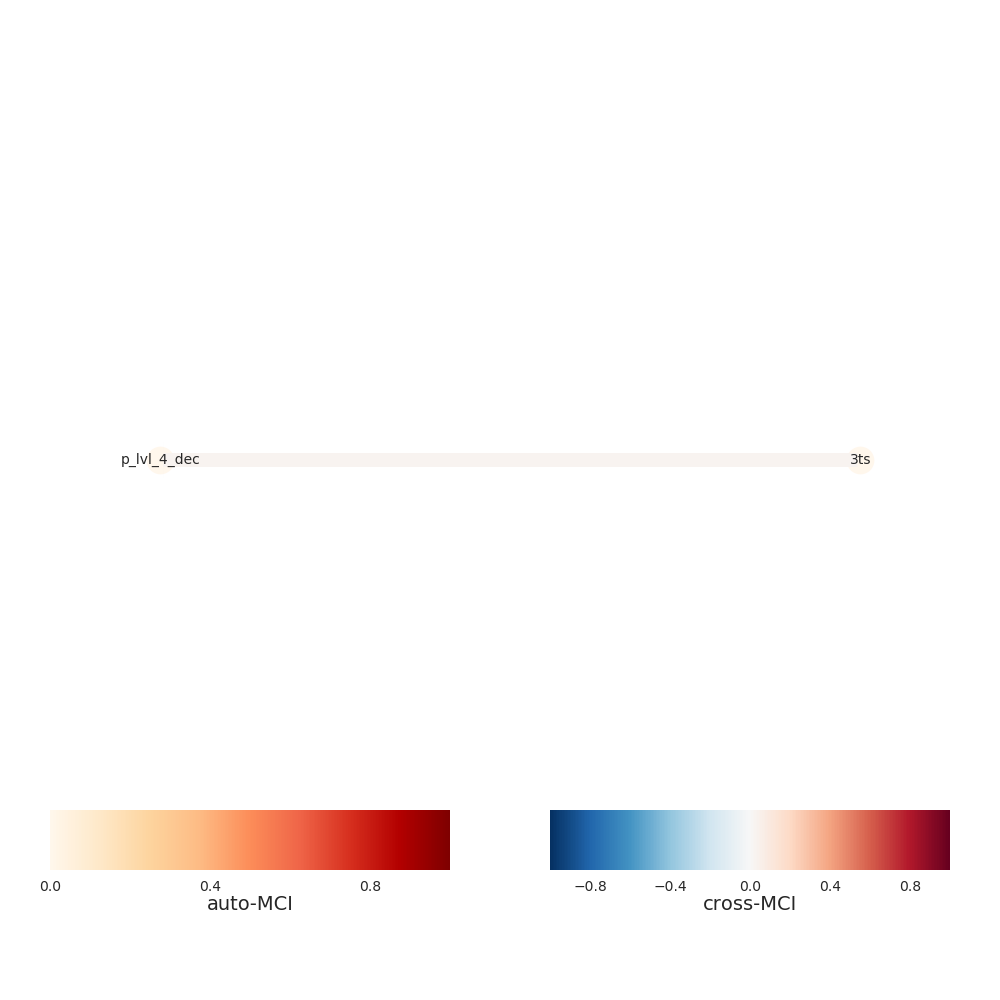

Progress causal inference - traintest set 100%

In [182]:
res_no_lag_ = run_experiment_levels(prepro_target, prepro_precursor_2, rg, rg_index, peak_test=False)

<IPython.core.display.Javascript object>


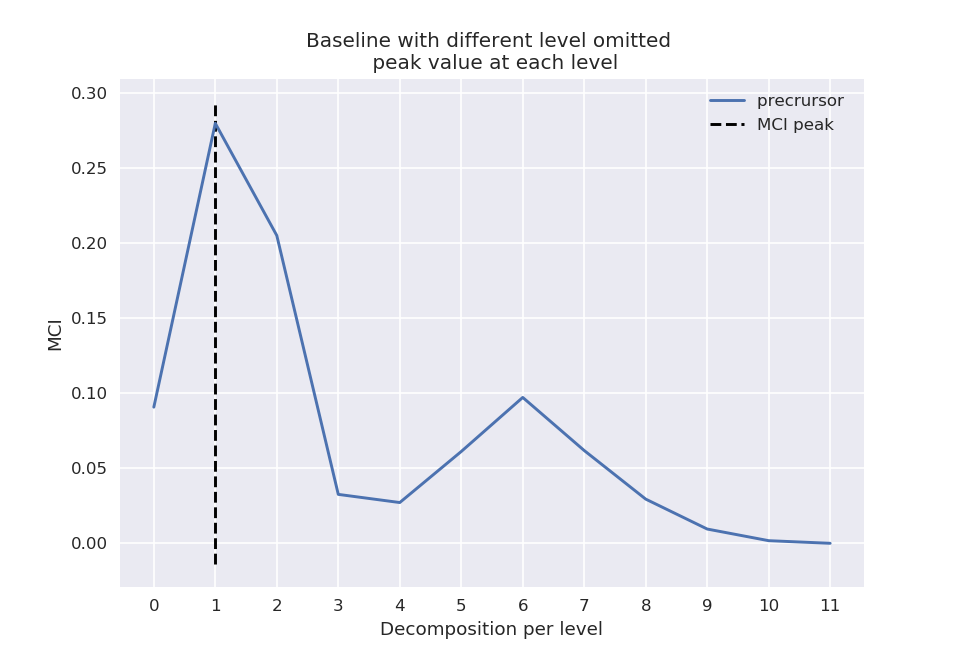

In [183]:
plot_mci_pred_relation(cA=np.arange(len(res_no_lag_[0])), prec_lag=res_no_lag_[0], path=' ', title=f'Baseline with different level omitted \n peak value at each level', show_level=True, savefig=False)

### Test plain with lag included

[INFO] Lag included in PCMCI step
Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


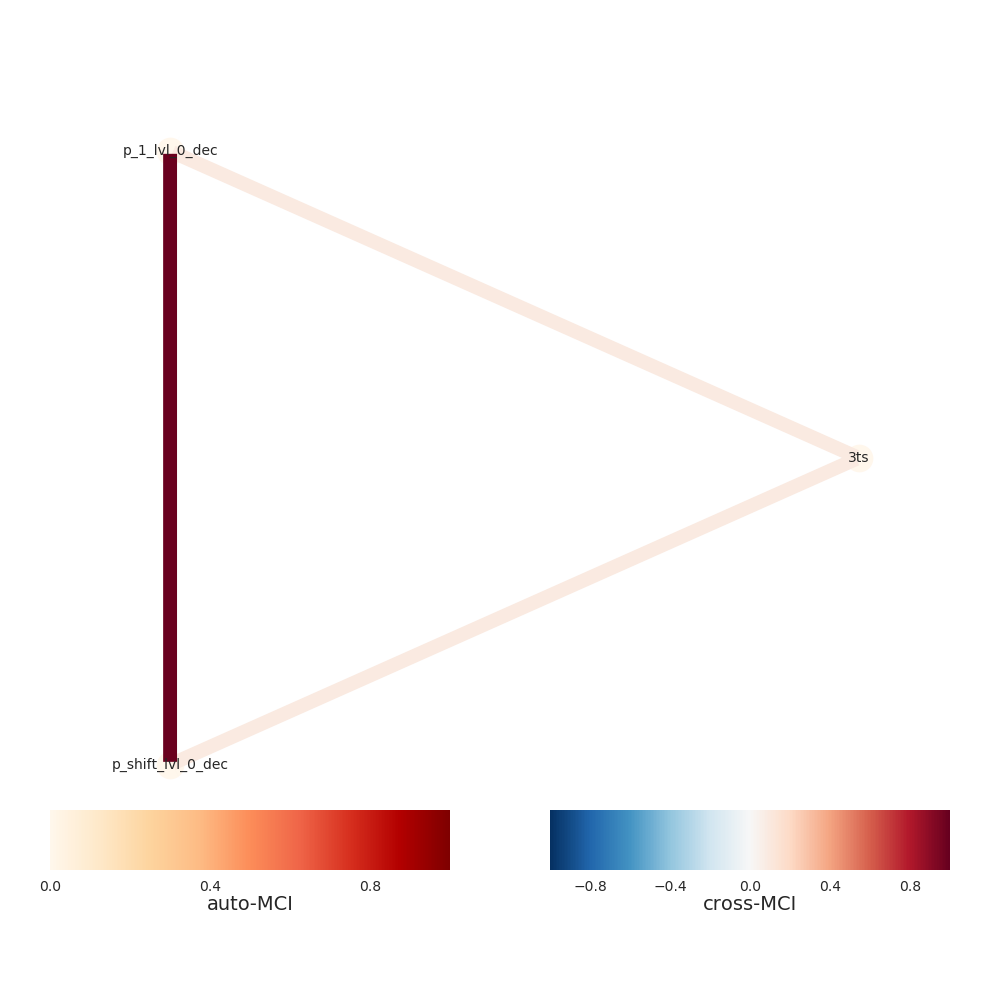

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


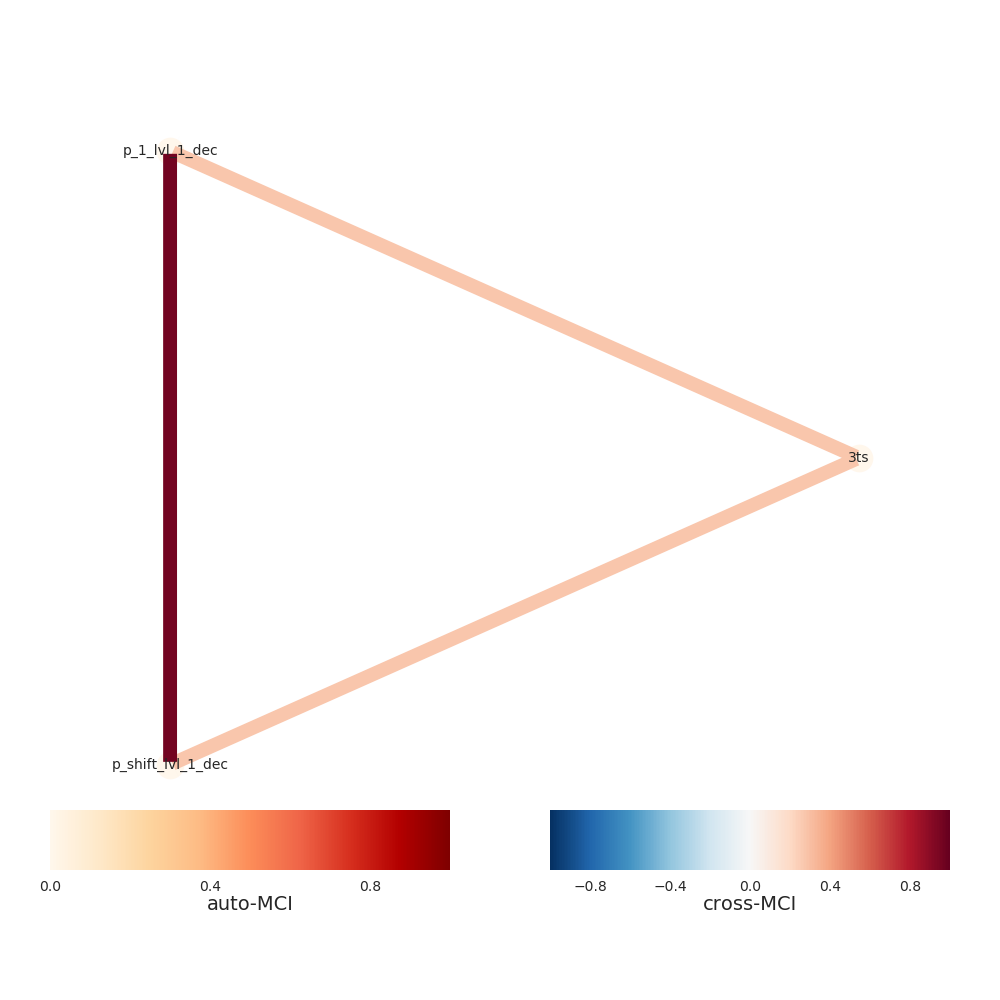

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


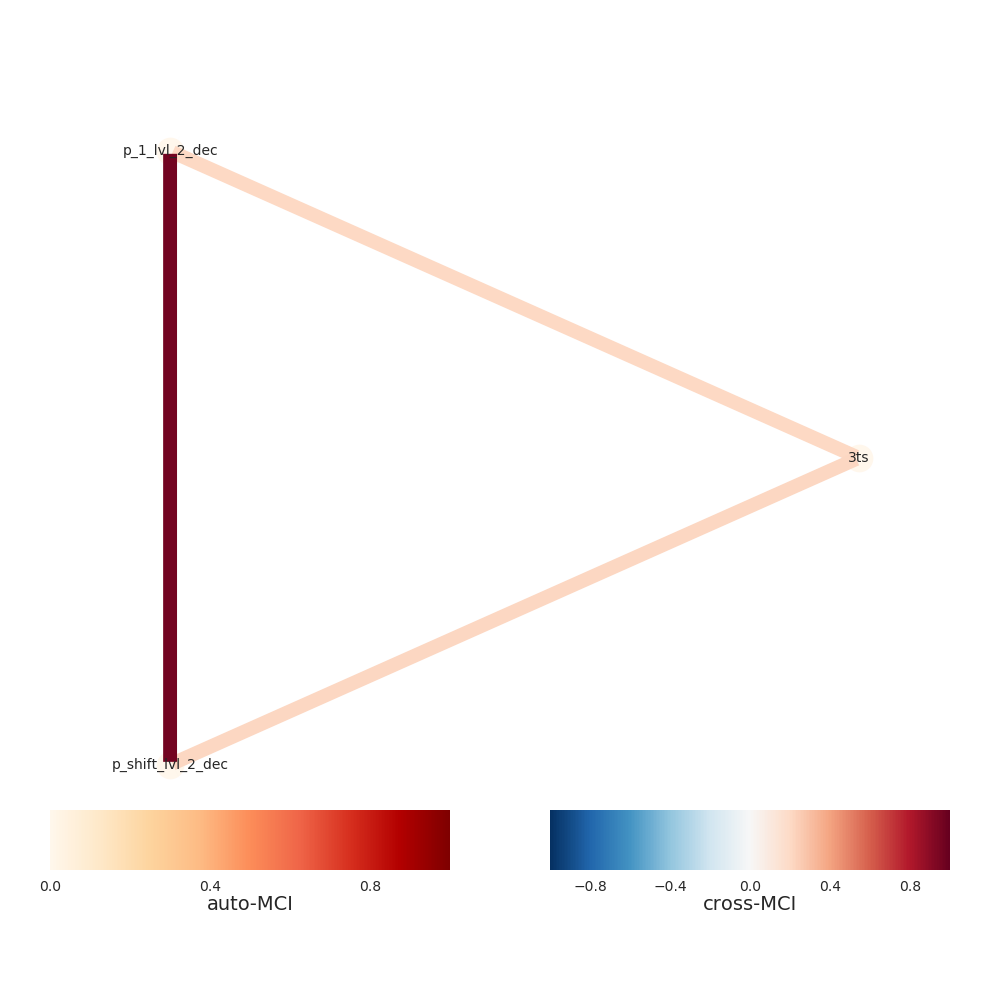

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


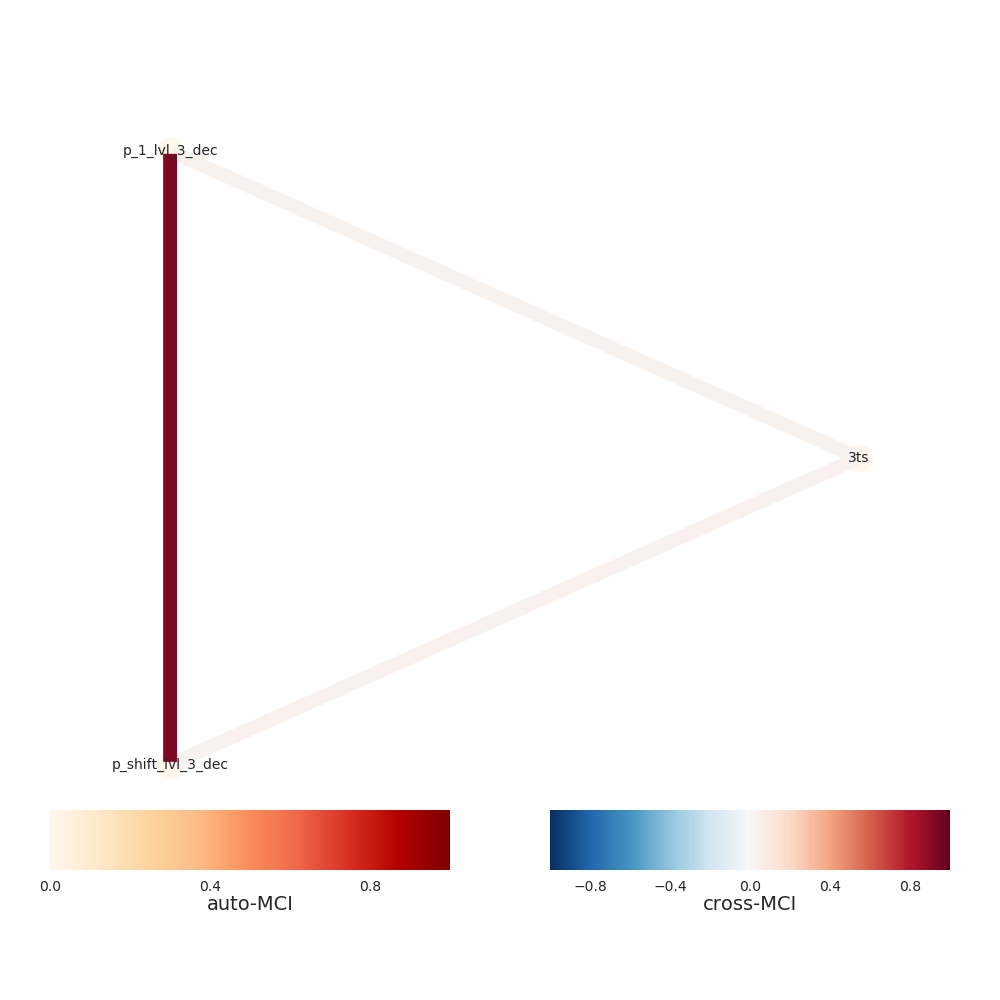

Progress causal inference - traintest set 100%

<IPython.core.display.Javascript object>


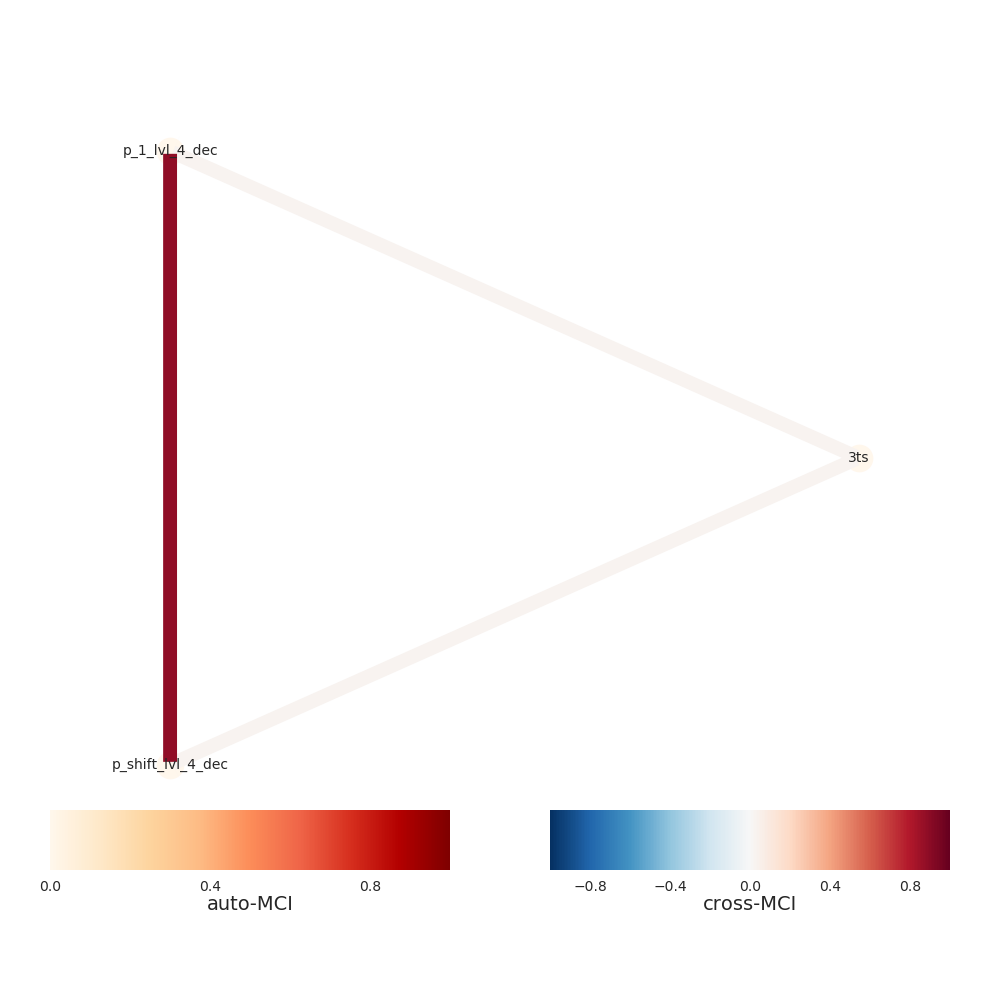

Progress causal inference - traintest set 100%

In [184]:
result_with_lag_ = run_experiment_levels(prepro_target, prepro_precursor_2, rg, rg_index, peak_test=True,total_levels=levels)

<IPython.core.display.Javascript object>


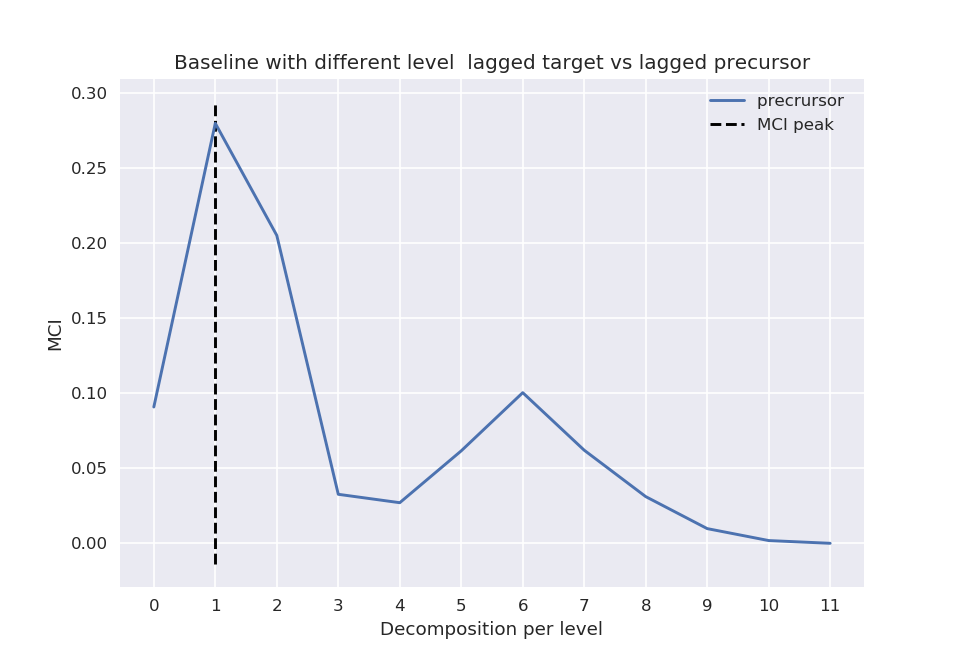

In [185]:
# for i, peak in enumerate(result_no_lag_):
#     if abs(len(result_no_lag_) - len(peak)) == 1:
#         plot_mci_pred_relation(cA=range(len(result_no_lag_)-1), prec_lag=peak, path=' ', title=f'Baseline with different level {str(levels[i])} omitted \n lag shift included {str(2**(levels[i]))} days \n in precursor and target', show_level=True, savefig=False)
#     else:
#         plot_mci_pred_relation(cA=range(len(result_no_lag_)), prec_lag=peak, path=' ', title=f'Baseline with different level {str(levels[i])} omitted \n lag shift included {str(2**(levels[i]))} days \n in precursor and target', show_level=True, savefig=False)
plot_mci_pred_relation(cA=range(len(result_with_lag_[0])), prec_lag=result_with_lag_[0], path=' ', title=f'Baseline with different level  lagged target vs lagged precursor', show_level=True, savefig=False)

### Experiment with noise 

#### Noise with no lag included

In [186]:
result_noise_ = run_experiment_levels_noise(prepro_target, prepro_precursor_2 ,rg, rg_index, w=la8, peak_test=False, modwt=True, mode=wv.Modes.periodic, total_levels=levels, iterations=10, thetas=theta)


[DEBUG] Running with noise 0.1

[DEBUG] Iiteration 0
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 1
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 4
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 5
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 6
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 7
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 8
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 9
Progress causal inference - traintest set 100%
[DEBUG] Running with noise 0.2

[DEBUG] Iiteration 0
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 1
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
Progress causal inference - tr

<IPython.core.display.Javascript object>


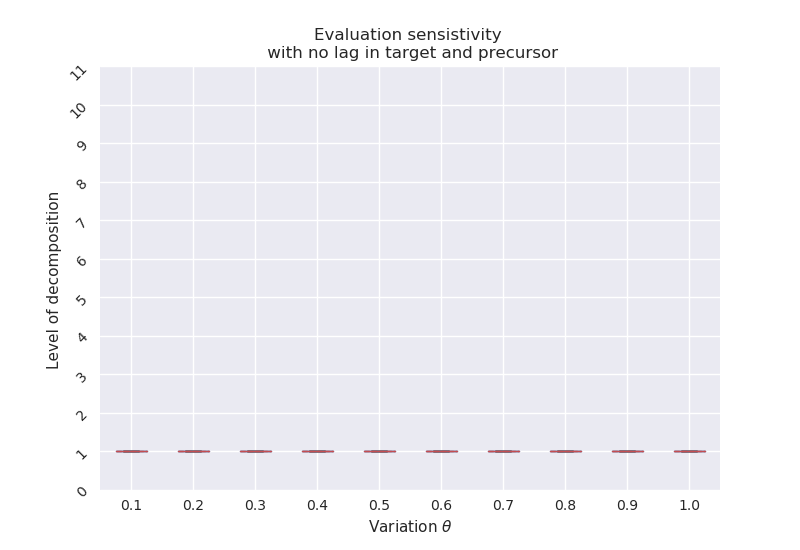

In [188]:
%matplotlib notebook
box_plot_reesult_experiments(result_noise_, level=levels, theta=theta, title='Evaluation sensistivity \n with no lag in target and precursor')

#### Noise with lag included

In [135]:
result_noise_lag = run_experiment_levels_noise(prepro_target, prepro_precursor_2 ,rg, rg_index, w=la8, peak_test=True, modwt=True, mode=wv.Modes.periodic, total_levels=levels, iterations=10, thetas=theta)


[DEBUG] Running with noise 0.1

[DEBUG] Iiteration 0
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 1
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 4
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 5
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 6
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 7
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 8
[INFO] Appropriate level is changed to  11
Progress causal

Progress causal inference - traintest set 100%
[DEBUG] Iiteration 2
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 3
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 4
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 5
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 6
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 7
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 8
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Iiteration 9
[INFO] Appropriate level is changed to  11
Progress causal inference - traintest set 100%
[DEBUG] Running with noise 0.9

[DEBUG] Iiteration 0
[INFO] Appro

<IPython.core.display.Javascript object>


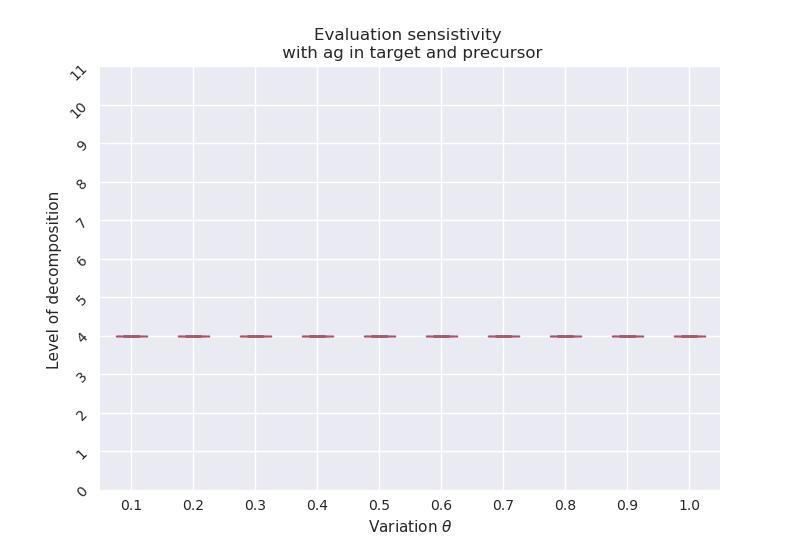

In [136]:
%matplotlib notebook
box_plot_reesult_experiments(result_noise_lag, level=levels, theta=theta, title='Evaluation sensistivity \n with ag in target and precursor')